In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
import joblib
import os
%matplotlib inline

In [2]:
train=pd.read_csv('train_data.csv')
test=pd.read_csv('test_data.csv')

In [3]:
train.shape , test.shape

((29165, 20), (7292, 20))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29165 entries, 0 to 29164
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   29165 non-null  int64  
 1   Gender               29165 non-null  object 
 2   Has a car            29165 non-null  object 
 3   Has a property       29165 non-null  object 
 4   Children count       29165 non-null  int64  
 5   Income               29165 non-null  float64
 6   Employment status    29165 non-null  object 
 7   Education level      29165 non-null  object 
 8   Marital status       29165 non-null  object 
 9   Dwelling             29165 non-null  object 
 10  Age                  29165 non-null  int64  
 11  Employment length    29165 non-null  int64  
 12  Has a mobile phone   29165 non-null  int64  
 13  Has a work phone     29165 non-null  int64  
 14  Has a phone          29165 non-null  int64  
 15  Has an email         29165 non-null 

In [5]:
train.describe()

,ID,Children count,Income,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Family member count,Account age,Is high risk
count,2.916500e+04,29165.000000,2.916500e+04,29165.000000,29165.000000,29165.0,29165.000000,29165.000000,29165.000000,29165.000000,29165.000000,29165.000000
mean,5.078232e+06,0.430790,1.868904e+05,-15979.477490,59257.761255,1.0,0.224310,0.294977,0.090279,2.197531,-26.137734,0.017110
std,4.182400e+04,0.741882,1.014096e+05,4202.997485,137655.883458,0.0,0.417134,0.456040,0.286587,0.912189,16.486702,0.129682
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,5.042047e+06,0.000000,1.215000e+05,-19444.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,0.000000
50%,5.074666e+06,0.000000,1.575000e+05,-15565.000000,-1557.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,0.000000
75%,5.114629e+06,1.000000,2.250000e+05,-12475.000000,-412.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,0.000000
max,5.150485e+06,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,1.000000


### Function that will return the value count and frequency of each observation within a feature


In [6]:
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

### Function to create display general information about the feature


In [7]:
def gen_info_feat(df,feature):
    match feature:
        case 'Age':
            # change the feature to be express in positive numbers days
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case 'Employment length':
            # select only the rows where the rows are negative to ignore whose who have retired or unemployed
            employment_len_no_ret = train['Employment length'][train['Employment length'] < 0]
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_len_no_ret.dtype))
        case 'Account age':
            # change the account age to a positive number of months
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

### Function to create a pie chart plot


In [8]:
def create_pie_plot(df,feature):
    match feature:
        case 'Dwelling' | 'Education level':
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best',labels=ratio_size.index)
            plt.axis('equal')
            return plt.show()
        case _:
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best')
            plt.axis('equal')
            return plt.show()

### Function to create a bar chart plot


In [9]:
def create_bar_plot(df,feature):
    match feature:
        case 'Marital status' | 'Dwelling' | 'Job title' | 'Employment status' | 'Education level':
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

### function to create a box plot

In [10]:
def create_box_plot(df,feature):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(2,8))
            # change the feature to be express in positive numbers days
            sns.boxplot(y=np.abs(df[feature])/365.25)
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case 'Children count':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,df[feature].max(),1))
            return plt.show()
        case 'Employment length':
            fig, ax = plt.subplots(figsize=(2,8))
            employment_len_no_ret = train['Employment length'][train['Employment length'] < 0]
            # employement length in days is a negative number so we need to change it to positive and change it to days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            sns.boxplot(y=employment_len_no_ret_yrs)
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=np.abs(df[feature]))
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

### Function to create a histogram plot


In [11]:
def create_hist_plot(df,feature, the_bins=50):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(18,10))
            # change the feature to be express in positive numbers days
            sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # suppress scientific notation
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Employment length':
            employment_len_no_ret = train['Employment length'][train['Employment length'] < 0]
            # change the feature to be express in positive numbers days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

### High risk vs low risk applicants compared on a box plot


In [12]:
def low_high_risk_box_plot(df,feature):
    match feature:
        case 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()
        case 'Employment length':
            #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
            employment_no_ret = train['Employment length'][train['Employment length'] <0]
            employment_no_ret_idx = employment_no_ret.index
            employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
            employment_no_ret_df = train.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
            employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
            # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
            print(np.abs(employment_no_ret_is_high_risk)/365.25)
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High vs low risk individuals grouped by {}'.format(feature))
            return plt.show()
        case _:
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()

### High risk vs low risk applicants compared on a bar plot


In [13]:
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

# EDA

## Univariate Analysis

### 1. Gender

In [14]:
gen_info_feat(train,'Gender')

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
F  19549      67.028973
M   9616      32.971027


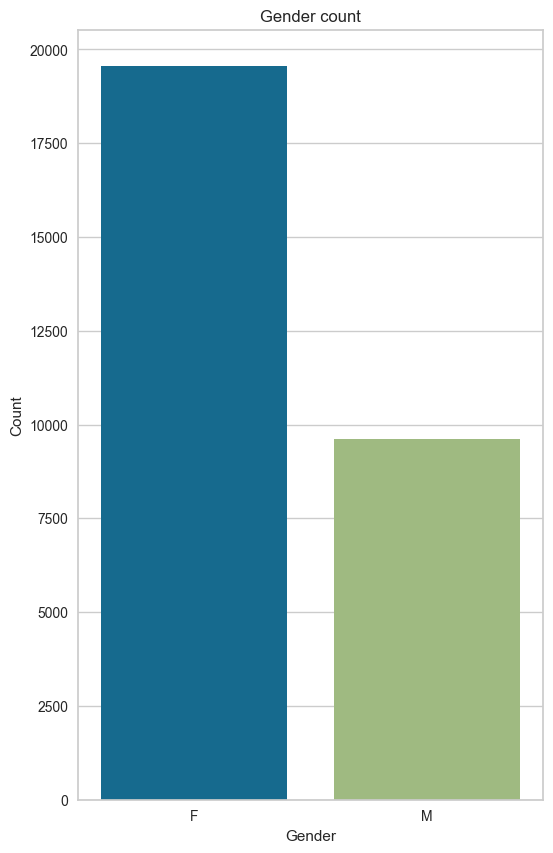

In [15]:
create_bar_plot(train,'Gender')

### 2. Age

In [16]:
gen_info_feat(train,'Age')

Description:
count    29165.000000
mean        43.749425
std         11.507180
min         21.095140
25%         34.154689
50%         42.614648
75%         53.234771
max         68.862423
Name: Age, dtype: float64
**************************************************
Object type:int64


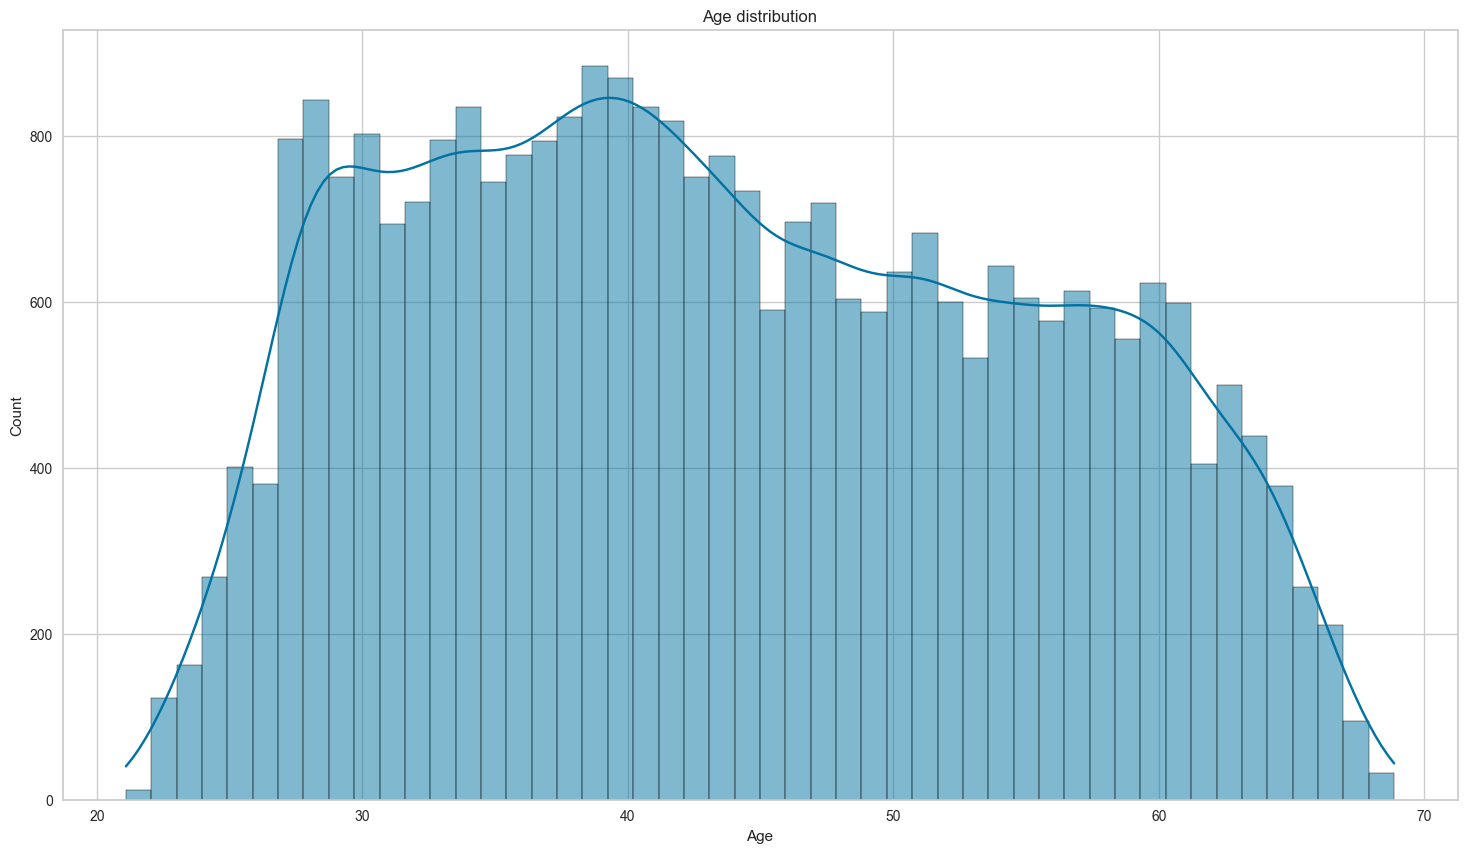

In [17]:
create_hist_plot(train,'Age')

#### bivariate analysis with target variable

Is high risk
0    43.753103
1    43.538148
Name: Age, dtype: float64


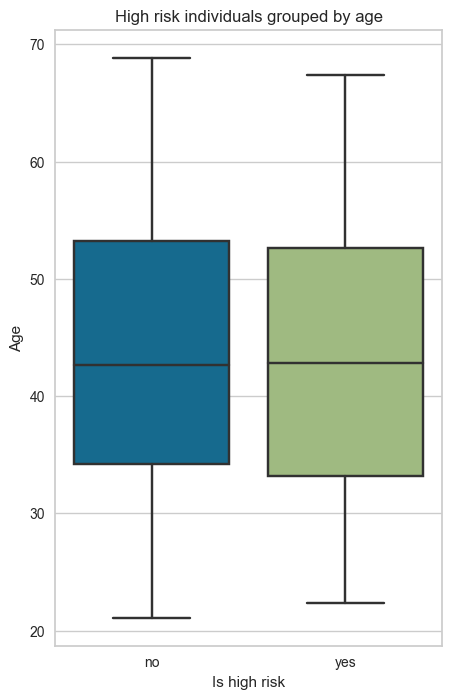

In [18]:
low_high_risk_box_plot(train,'Age')

- The youngest applicant is 21 years old while the oldest is 68 years old. with the average of 43.7 and median of 42.6(outliers insensitive)
- Age feature is not normally distributed, it is slightly positively skew
- There is no difference between the average age of high and low risk applicants

### 3.Marital status

In [19]:
gen_info_feat(train,'Marital status')

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Married               20044      68.726213
Single / not married   3864      13.248757
Civil marriage         2312       7.927310
Separated              1712       5.870050
Widow                  1233       4.227670


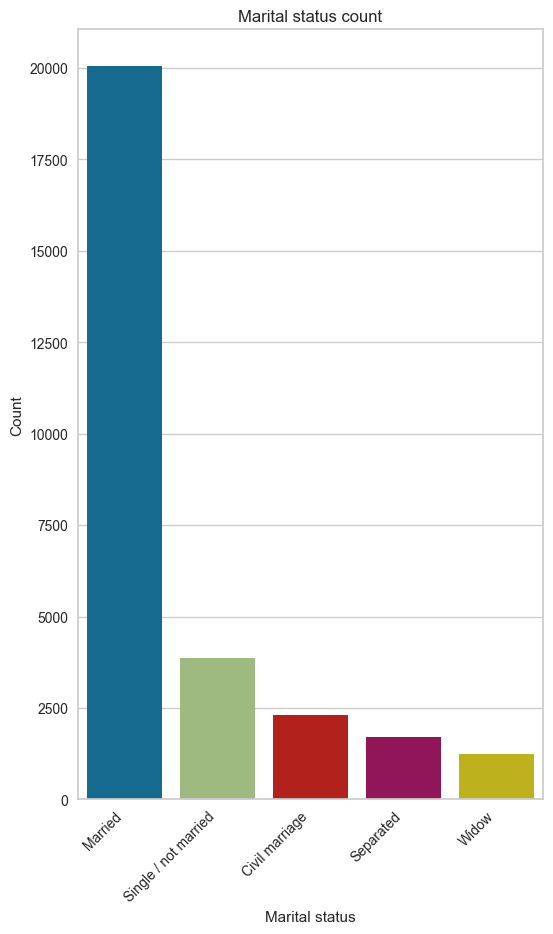

In [20]:
create_bar_plot(train,'Marital status')

{'Married': 320, 'Single / not married': 87, 'Civil marriage': 34, 'Widow': 34, 'Separated': 24}


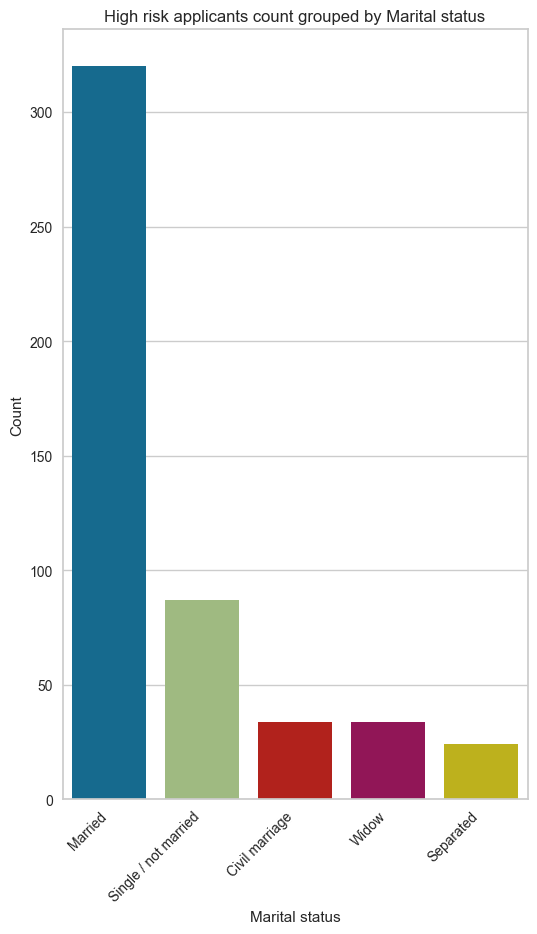

In [21]:
low_high_risk_bar_plot(train,'Marital status')

- Most applicants are married
- Even though we have a higher number of applicants who are separated than those who are widow, it seems like widow applicants are high risk than those who are separated.

### 4.Family member count

In [22]:
gen_info_feat(train,'Family member count')

Description:
count    29165.000000
mean         2.197531
std          0.912189
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
      Count  Frequency (%)
2.0   15552      53.324190
1.0    5613      19.245671
3.0    5121      17.558718
4.0    2503       8.582205
5.0     309       1.059489
6.0      48       0.164581
7.0      14       0.048003
9.0       2       0.006858
15.0      2       0.006858
20.0      1       0.003429


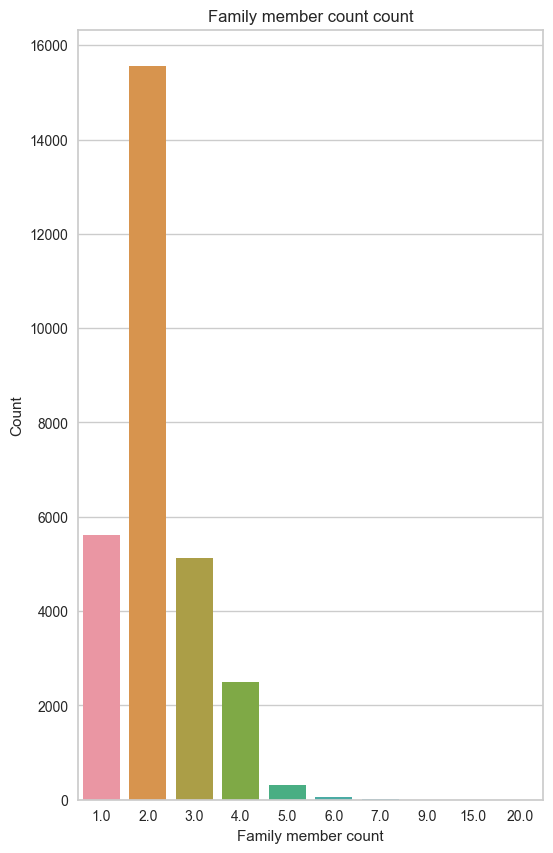

In [23]:
create_bar_plot(train,'Family member count')

- Most applicants are two in their household, this is also confirmed with the fact that most don’t have a child (more on this in a bit)
- We also have 6 outliers, 2 of them are extreme with 20 and 15 members in their household

### 5.Children count

In [24]:
gen_info_feat(train,'Children count')

Description:
count    29165.000000
mean         0.430790
std          0.741882
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
    Count  Frequency (%)
0   20143      69.065661
1    6003      20.582890
2    2624       8.997086
3     323       1.107492
4      52       0.178296
5      15       0.051432
7       2       0.006858
14      2       0.006858
19      1       0.003429


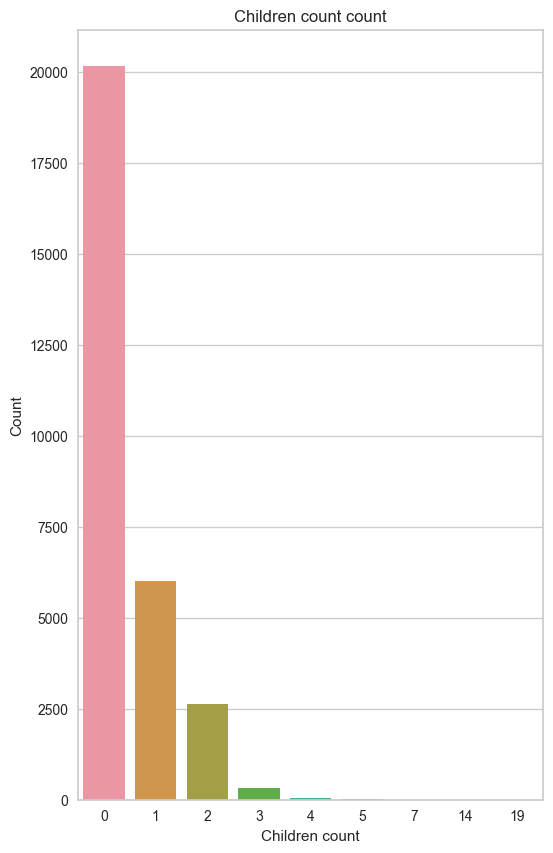

In [25]:
create_bar_plot(train,'Children count')

- As previously discussed most applicant don’t have a child
- Also here we have 6 outliers, probably the same from the family member count

### 6. Dwelling type

In [26]:
gen_info_feat(train,'Dwelling')

Description:
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                     Count  Frequency (%)
House / apartment    26059      89.350249
With parents          1406       4.820847
Municipal apartment    912       3.127036
Rented apartment       453       1.553232
Office apartment       208       0.713184
Co-op apartment        127       0.435453


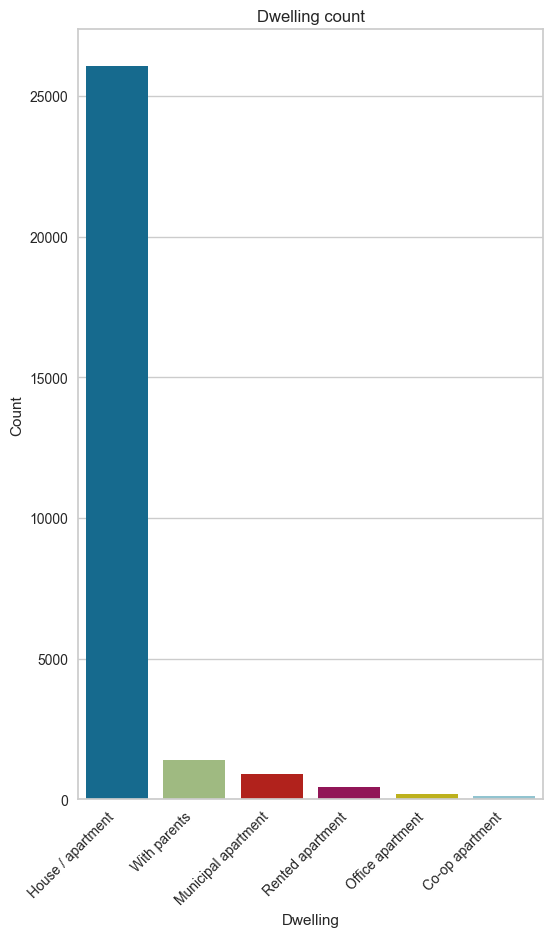

In [27]:
create_bar_plot(train,'Dwelling')

- Almost every applicants live in house or apartment

### 7. income

In [28]:
gen_info_feat(train,'Income')

Description:
count    2.916500e+04
mean     1.868904e+05
std      1.014096e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: Income, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
          Count  Frequency (%)
135000.0   3468      11.890965
180000.0   2487       8.527344
157500.0   2469       8.465627
225000.0   2373       8.136465
112500.0   2359       8.088462
...         ...            ...
164250.0      1       0.003429
42300.0       1       0.003429
432000.0      1       0.003429
145350.0      1       0.003429
82350.0       1       0.003429

[259 rows x 2 columns]


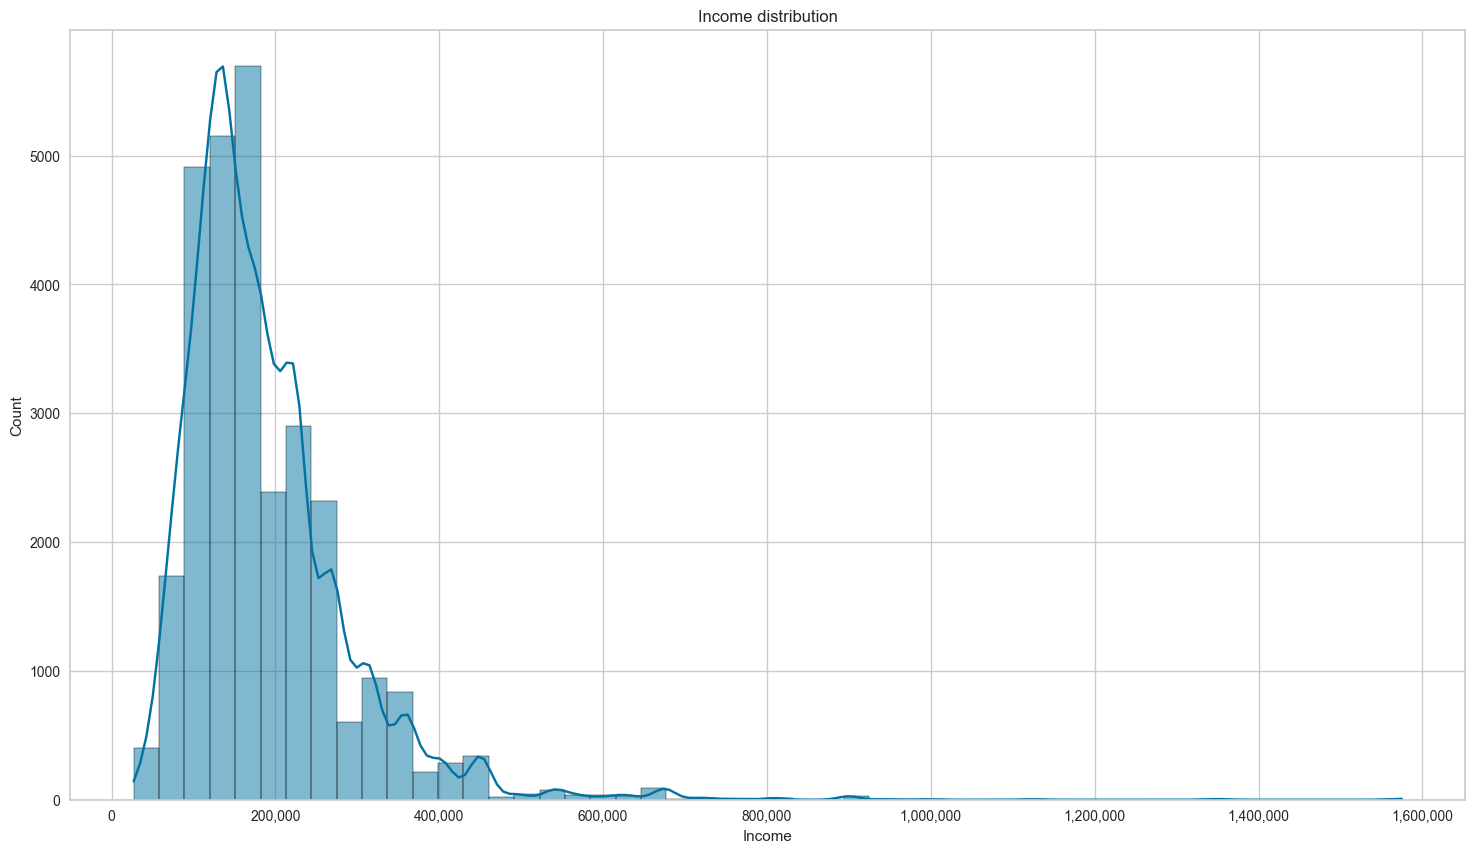

In [29]:
create_hist_plot(train,'Income')

Is high risk
0    186913.939650
1    185537.263527
Name: Income, dtype: float64


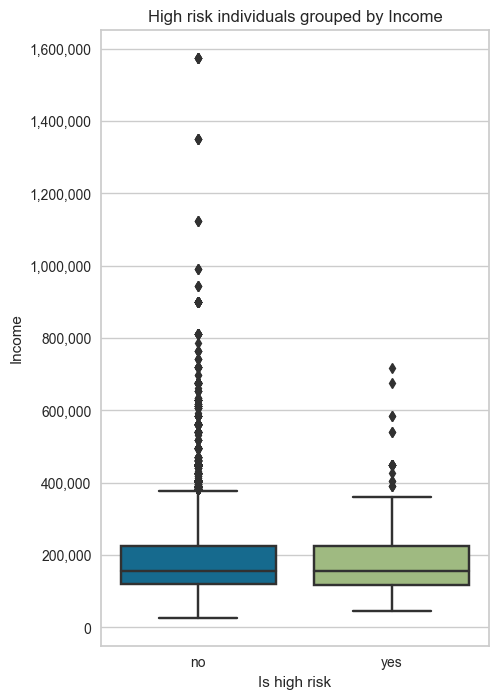

In [30]:
low_high_risk_box_plot(train,'Income')

- The average income is 186890 but this amount accounts for outliers. If we ignore the outlier most people make 157500
- We have 3 applicants who makes more than 1000000
- This  feature is positively skewed
- High risk and low risk applicants have roughly similar income

### 8. Job title

In [31]:
gen_info_feat(train,'Job title')

Description:
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Laborers                5004      24.848545
Core staff              2866      14.231801
Sales staff             2773      13.769987
Managers                2422      12.027014
Drivers                 1722       8.550998
High skill tech staff   1133       5.626179
Accountants              998       4.955805
Medicine staff           956       4.747244
Cooking staff            521       2.587149
Security staff           464       2.304102
Cleaning staff           425       2.110438
Private service staff    287       1.425166
Low-skill Laborers       138       0.685272
Waiters/barmen staff     127       0.630649
Secretaries              122       0.605820
HR staff                  72       0.3575

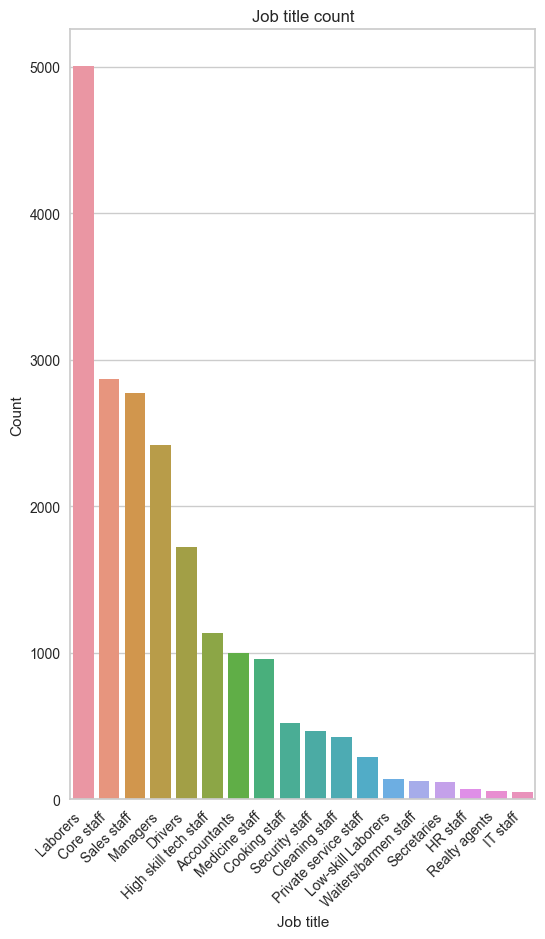

In [32]:
create_bar_plot(train,'Job title')

In [33]:
job_title_nan_count = train['Job title'].isna().sum()
job_title_nan_count

9027

In [34]:
rows_total_count = train.shape[0]

In [35]:
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 30.95 %


- The most prolific Job title is laborers by far

### 9 Employment status

In [36]:
gen_info_feat(train,'Employment status')

Description:
count       29165
unique          5
top       Working
freq        15056
Name: Employment status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Working               15056      51.623521
Commercial associate   6801      23.319047
Pensioner              4920      16.869535
State servant          2381       8.163895
Student                   7       0.024001


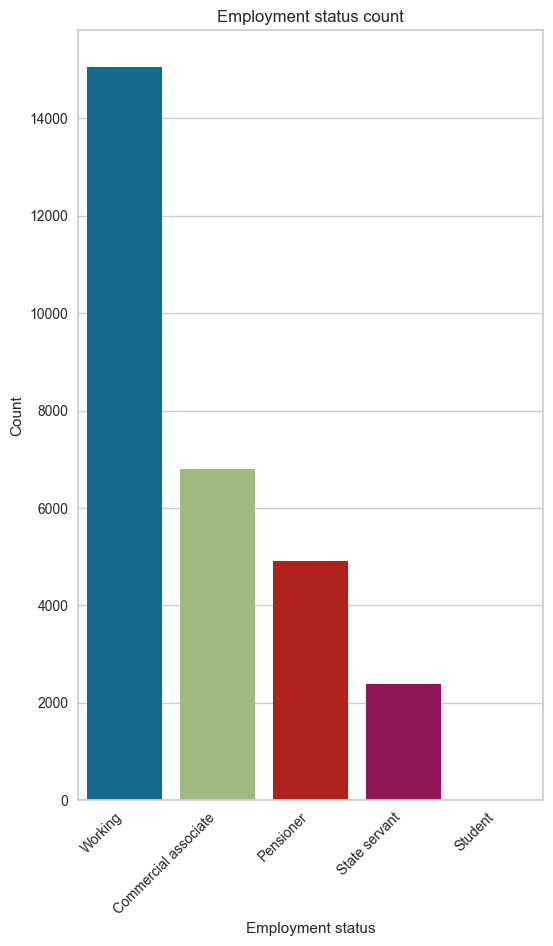

In [37]:
create_bar_plot(train,'Employment status')

- Most applicants are employed

### 10 Education level

In [38]:
gen_info_feat(train,'Education level')

Description:
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                               Count  Frequency (%)
Secondary / secondary special  19803      67.899880
Higher education                7910      27.121550
Incomplete higher               1129       3.871078
Lower secondary                  298       1.021773
Academic degree                   25       0.085719


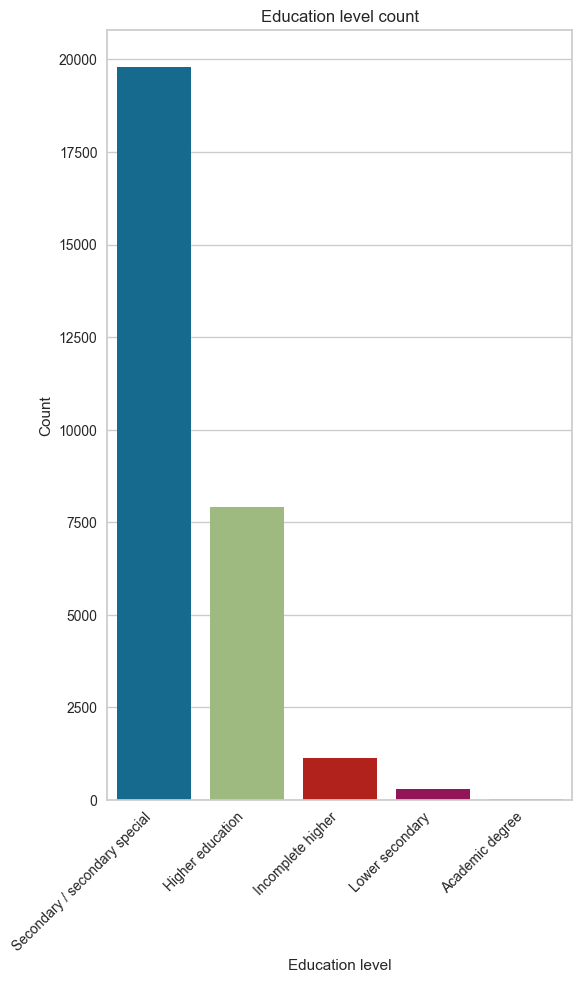

In [39]:
create_bar_plot(train,'Education level')

### 11 Employment length

In [40]:
gen_info_feat(train,'Employment length')

Description:
count    24257.000000
mean         7.264220
std          6.463364
min          0.046543
25%          2.683094
50%          5.451061
75%          9.598905
max         43.019849
Name: Employment length, dtype: float64
**************************************************
Object type:int64


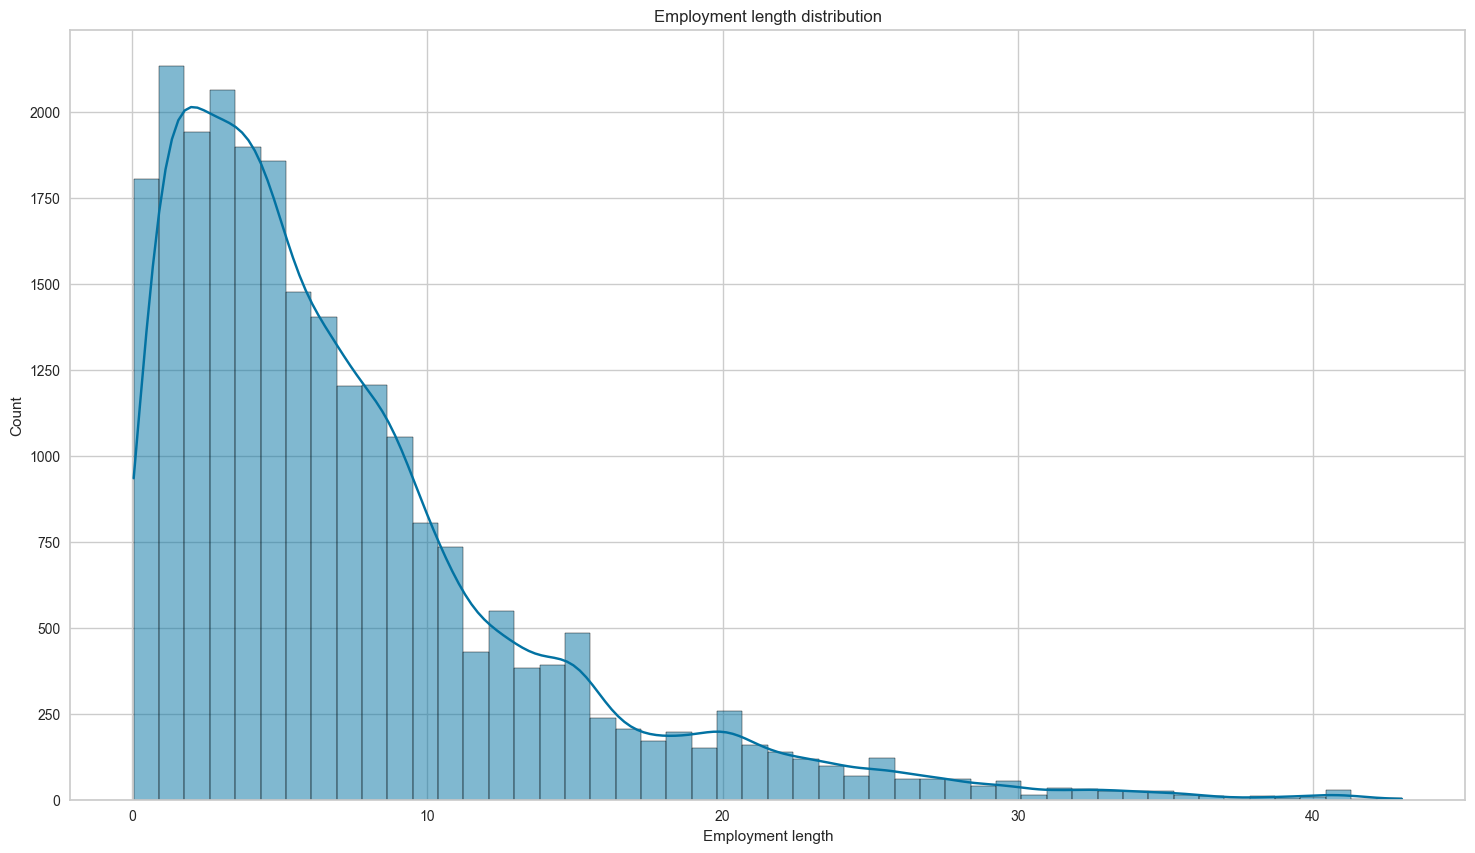

In [41]:
create_hist_plot(train,'Employment length')

Is high risk
0    7.290112
1    5.750701
Name: Employment length, dtype: float64


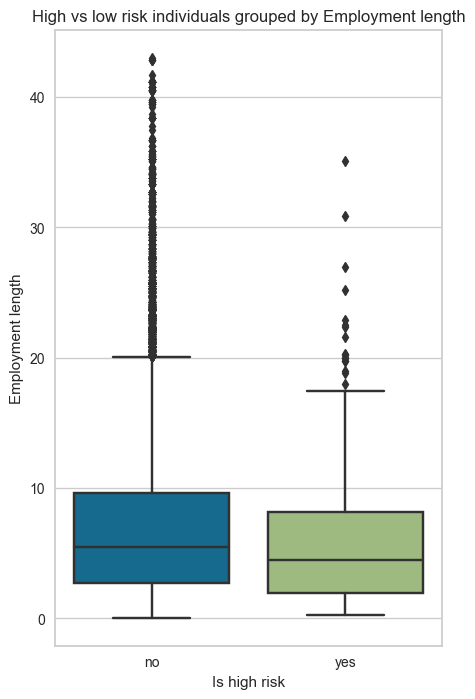

In [42]:
# distribution of employment length for high vs low risk applicants
# Here 0 means No and 1 means Yes
low_high_risk_box_plot(train,'Employment length')

- Most of applicant have been working for 5 to 7 years on average
- We have quite a number of outliers who have been working for more than 20 years+
- The employment length is positively skewed
- Those who are high risk have a low employment length of 5 versus 7 years for the low risk

### 12 Has a car

In [43]:
gen_info_feat(train,'Has a car')

Description:
count     29165
unique        2
top           N
freq      18128
Name: Has a car, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
N  18128      62.156695
Y  11037      37.843305


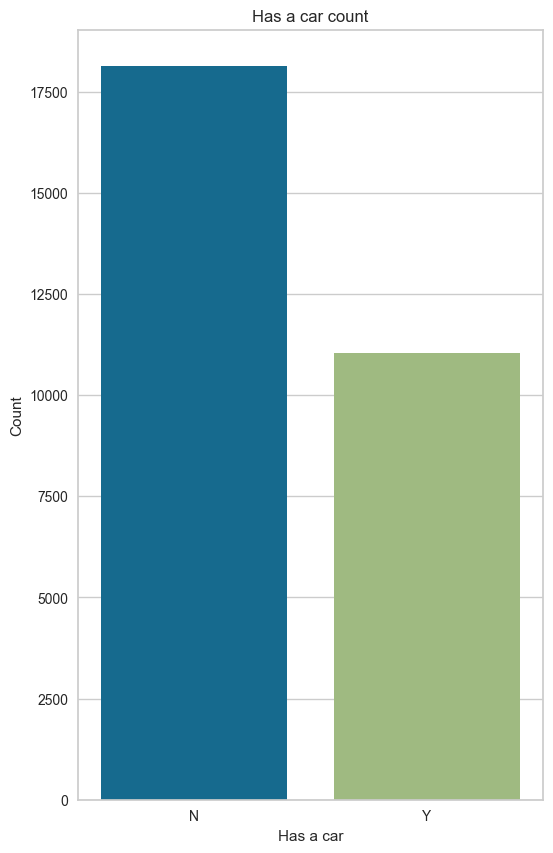

In [44]:
create_bar_plot(train,'Has a car')

- Most applicant don’t own a car

### 13 Has a property

In [45]:
gen_info_feat(train,'Has a property')

Description:
count     29165
unique        2
top           Y
freq      19557
Name: Has a property, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
Y  19557      67.056403
N   9608      32.943597


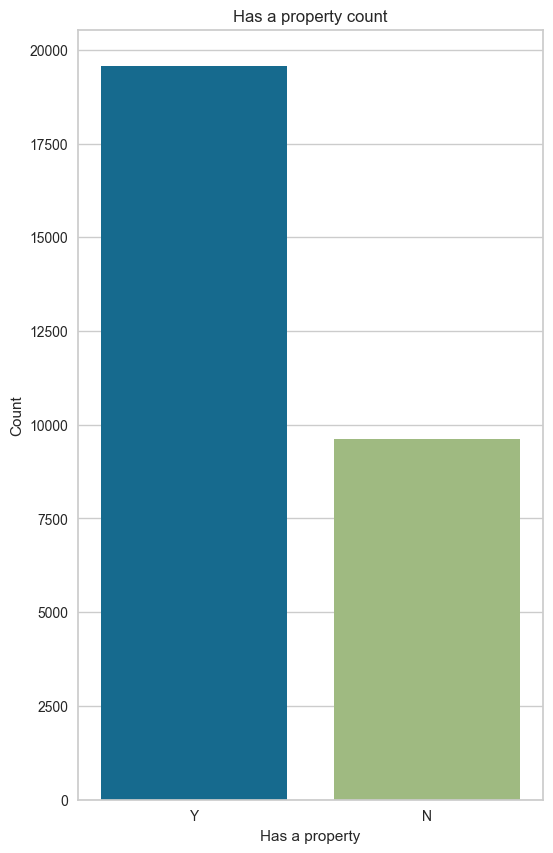

In [46]:
create_bar_plot(train,'Has a property')

- Most applicants own a property

### 14 Has a work phone

In [47]:
gen_info_feat(train,'Has a work phone')

Description:
count    29165.000000
mean         0.224310
std          0.417134
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Has a work phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  22623      77.569004
1   6542      22.430996


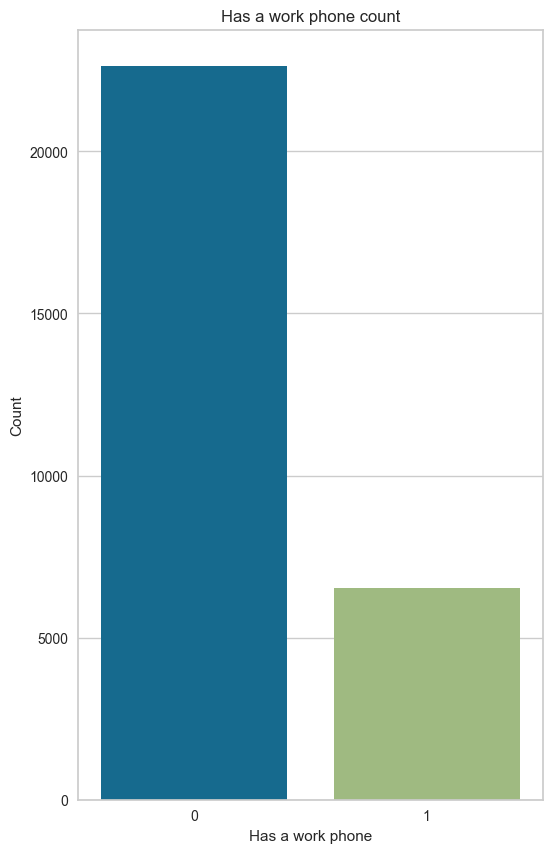

In [48]:
create_bar_plot(train,'Has a work phone')

### 15 Has a mobile phone

In [49]:
gen_info_feat(train,'Has a mobile phone')

Description:
count    29165.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: Has a mobile phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
1  29165          100.0


- All the applicants without exception have a mobile phone

### 16 Has a phone

In [50]:
gen_info_feat(train,'Has a phone')

Description:
count    29165.000000
mean         0.294977
std          0.456040
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Has a phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  20562      70.502314
1   8603      29.497686


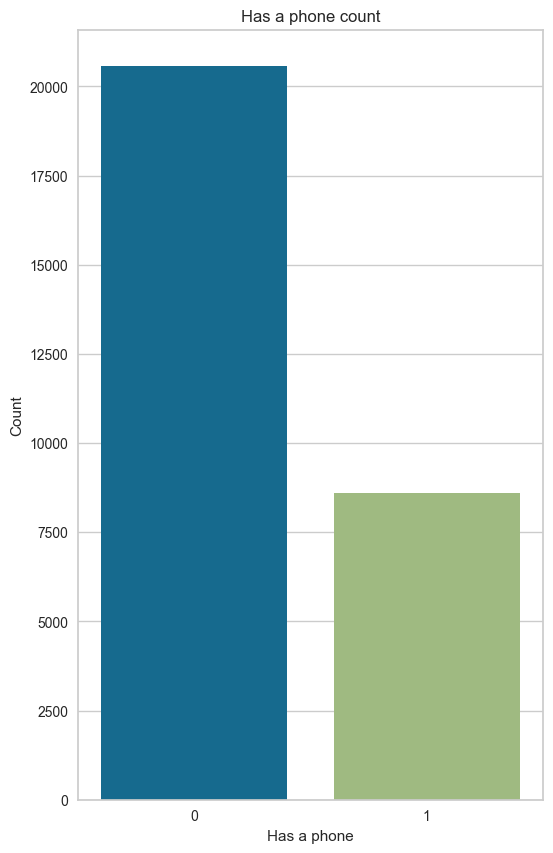

In [51]:
create_bar_plot(train,'Has a phone')

- Most applicants don’t have a phone (probably a home phone)

### 17 Has an email

In [52]:
gen_info_feat(train,'Has an email')

Description:
count    29165.000000
mean         0.090279
std          0.286587
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Has an email, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  26532      90.972056
1   2633       9.027944


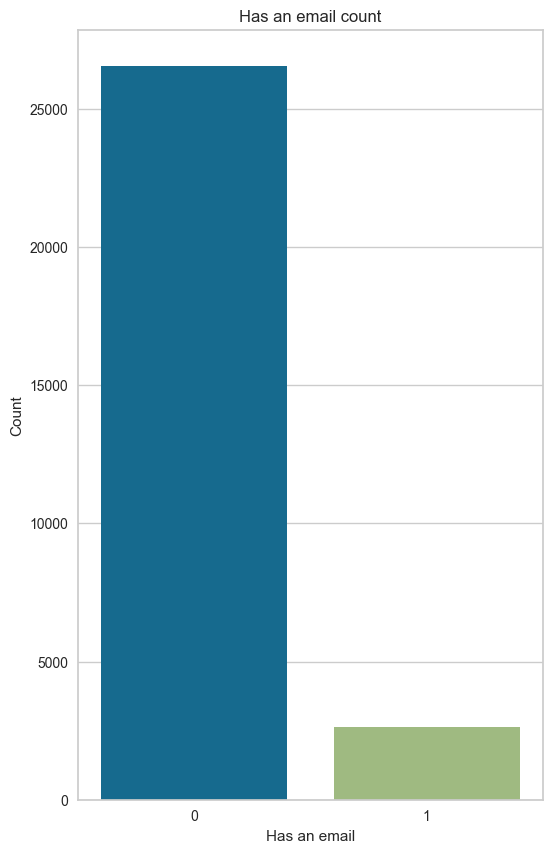

In [53]:
create_bar_plot(train,'Has an email')

- More than 90% of applicants don’t have an email

### 18 Account age

In [54]:
gen_info_feat(train,'Account age')

Description:
count    29165.000000
mean        26.137734
std         16.486702
min          0.000000
25%         12.000000
50%         24.000000
75%         39.000000
max         60.000000
Name: Account age, dtype: float64
**************************************************
Object type:float64


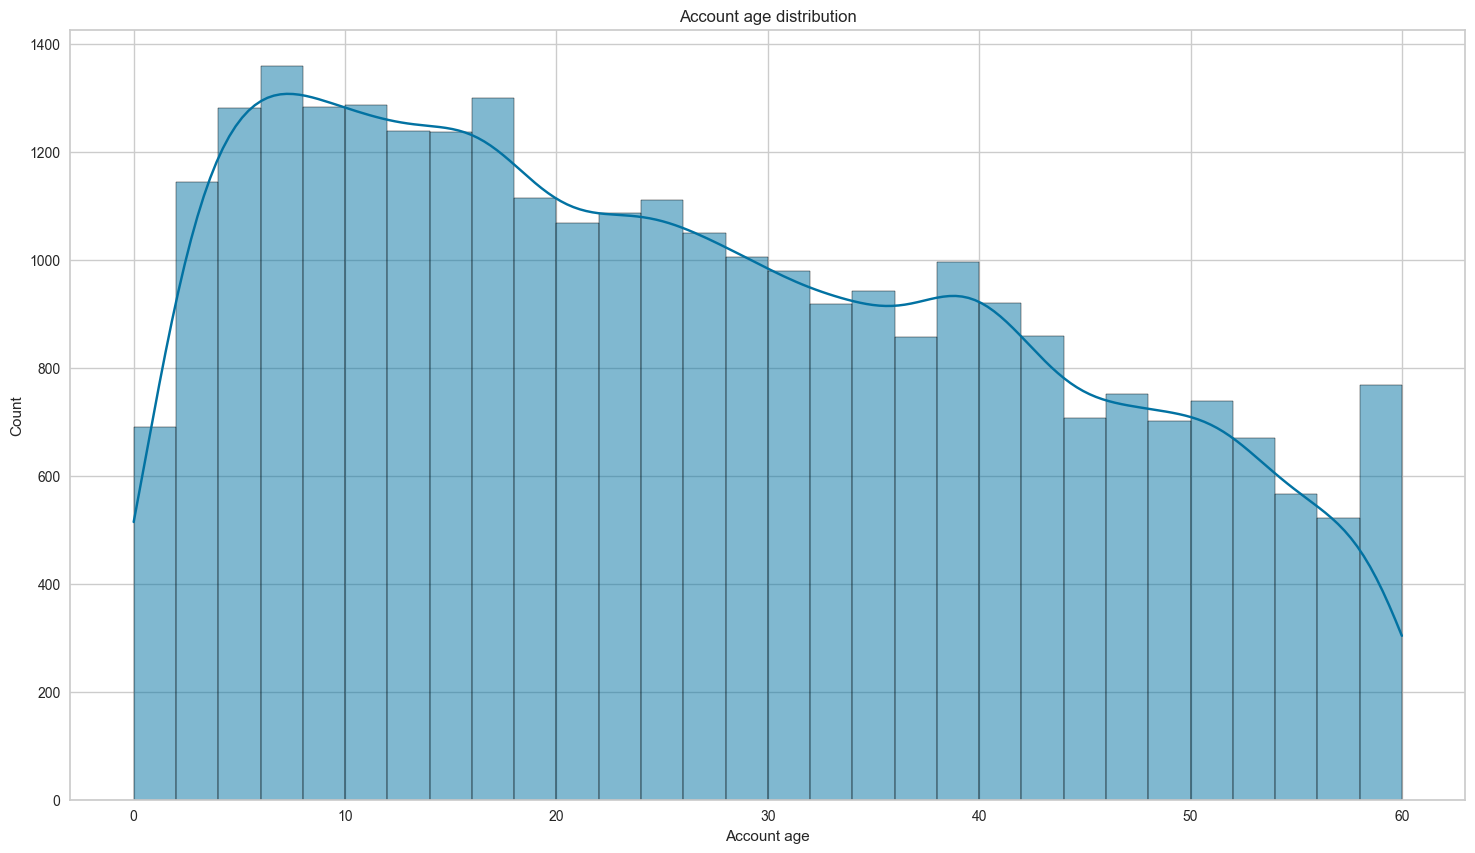

In [55]:
create_hist_plot(train,'Account age', the_bins=30)

Is high risk
0    26.000105
1    34.044088
Name: Account age, dtype: float64


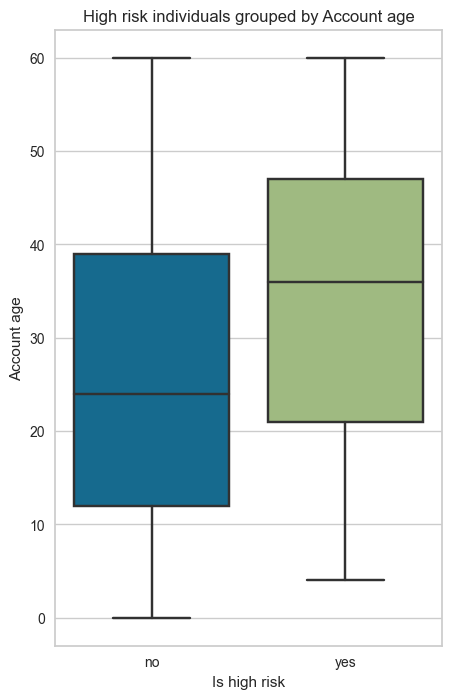

In [56]:
low_high_risk_box_plot(train,'Account age')

- Most accounts are 26 months old
- Account age is not normally distributed, it is positively skewed
- The accounts that have been flagged as high risk are on average 34 months old vs 26 months old for old account

### 19 Is high risk (target variable)

In [57]:
gen_info_feat(train,'Is high risk')

Description:
count    29165.000000
mean         0.017110
std          0.129682
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Is high risk, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  28666      98.289045
1    499       1.710955


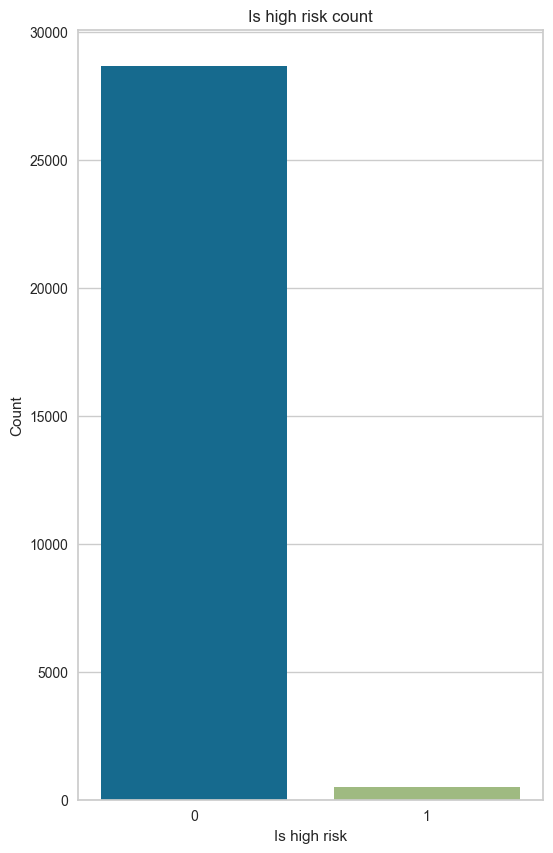

In [58]:
create_bar_plot(train,'Is high risk')

- A vast majority of applicants are low risk applicants.
- We have a very imbalance data.

## Bivariate analysis

### 1 Numerical vs numerical features (Correlation & scatter plots)

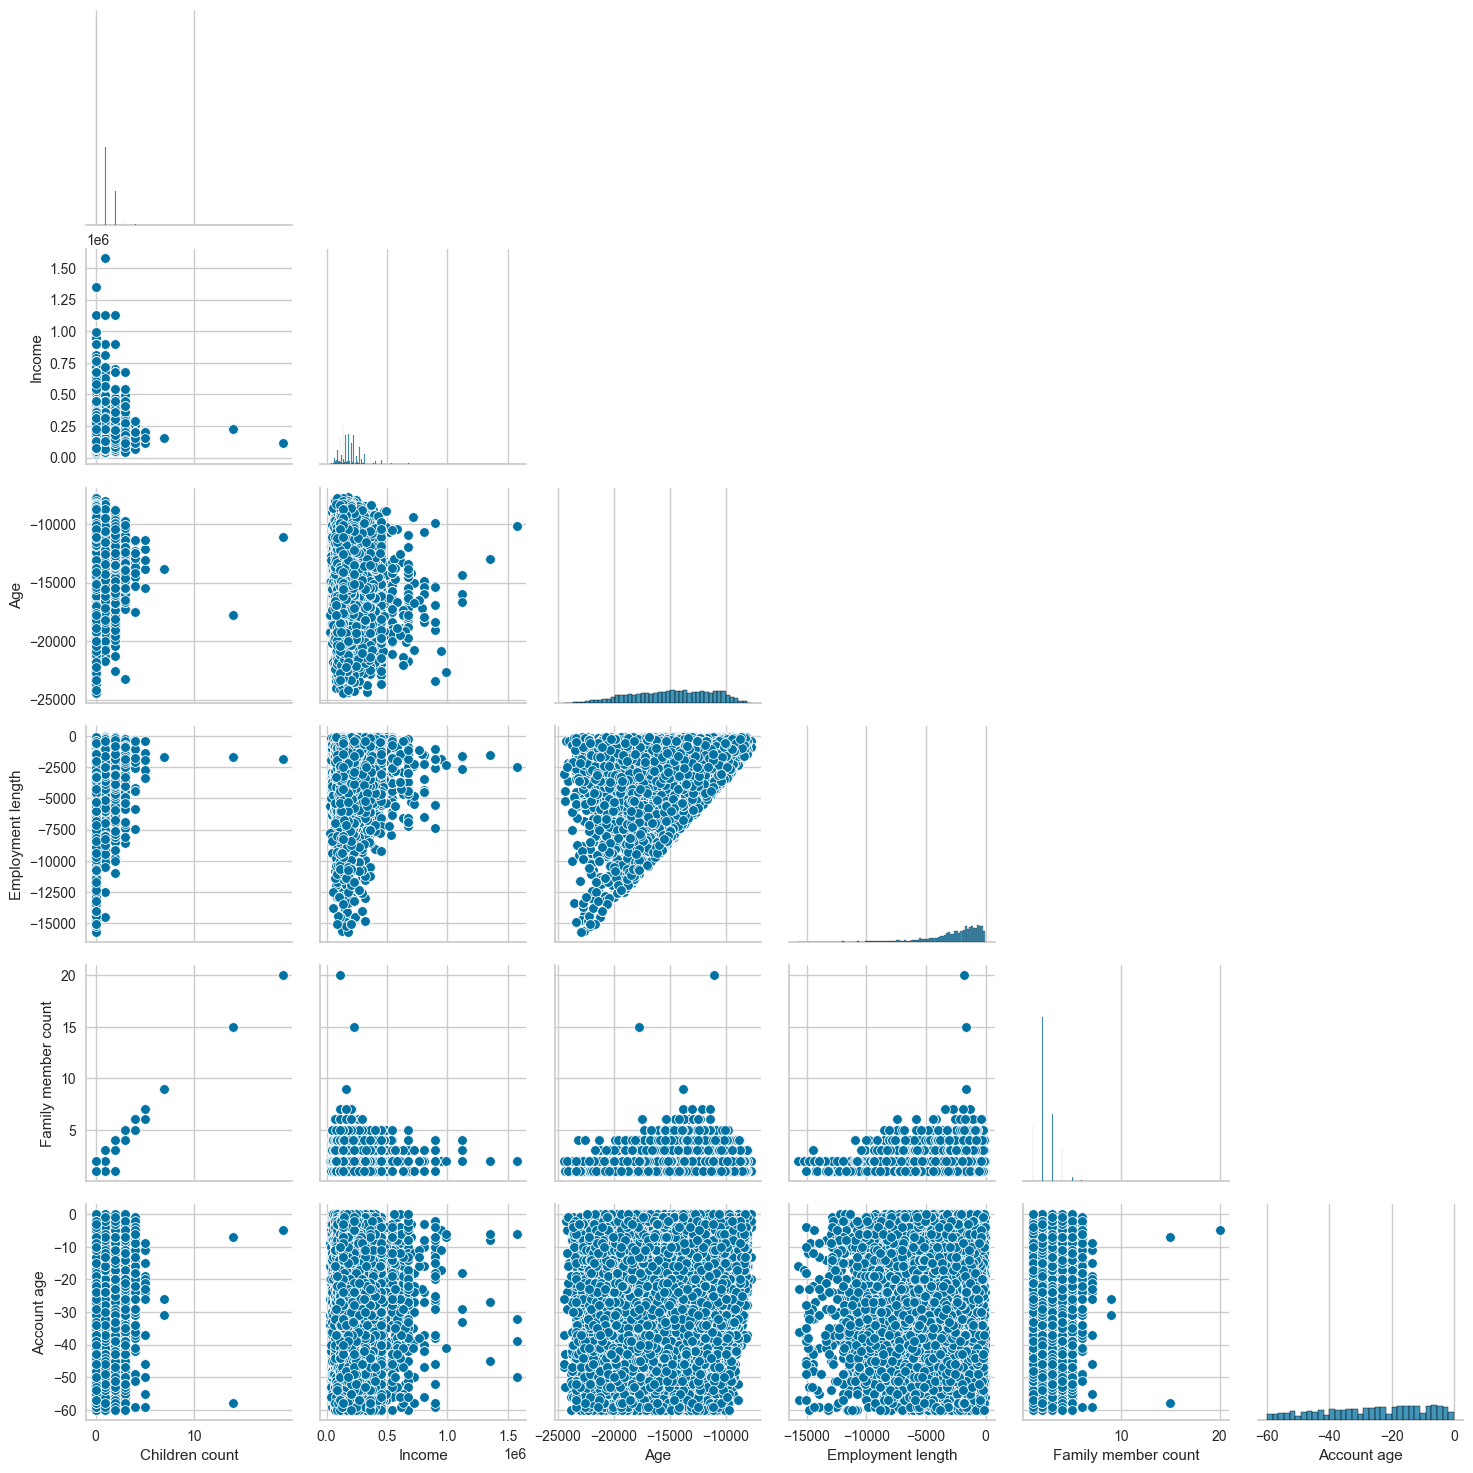

In [59]:
sns.pairplot(train[train['Employment length'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1),corner=True)
plt.show()

- We can see a positive linear correlation between the family member and the children count. This makes sense, the more the children someone have, the larger the family member count. This is a multicollinearity problem. Meaning that the features are highly correlated. We will need to drop one of them.
- Another interesting trend is the Employment length and age. This also makes sense, the longer the employee has been working, the older they are.

#### Correlation analysis 

In [60]:
# change the datatype of target feature to int
is_high_risk_int = train['Is high risk'].astype('int32')

C:\Users\prati\AppData\Local\Temp\ipykernel_39488\1188243117.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cc_train_copy_corr_no_mobile = pd.concat([train.drop(['Has a mobile phone','Is high risk'], axis=1),is_high_risk_int],axis=1).corr()


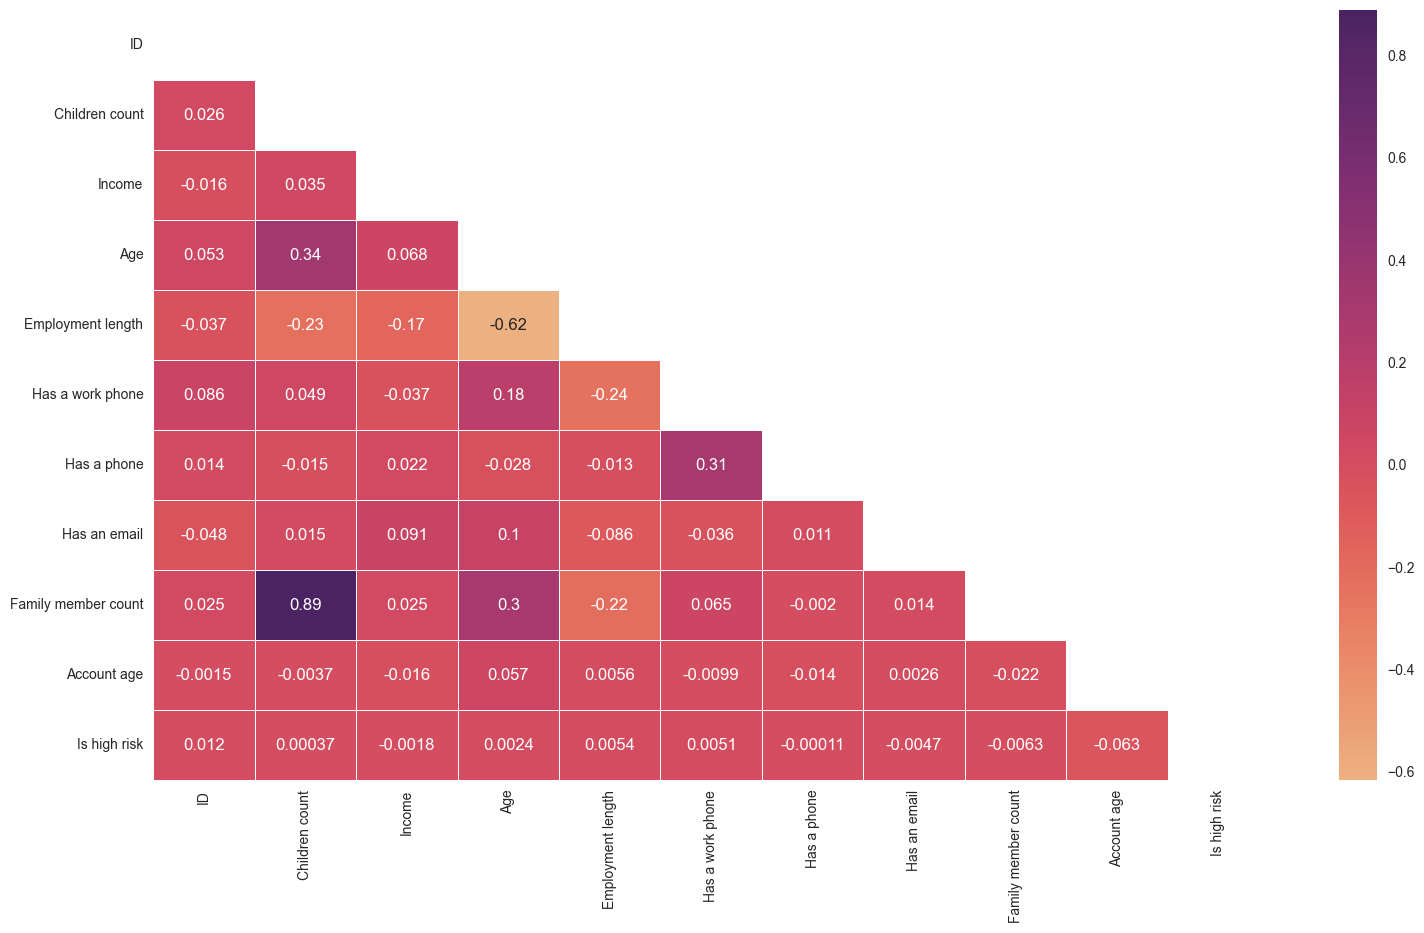

In [61]:
# correlation analysis with heatmap, after dropping the has a mobile phone with the target feature as int
cc_train_copy_corr_no_mobile = pd.concat([train.drop(['Has a mobile phone','Is high risk'], axis=1),is_high_risk_int],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(cc_train_copy_corr_no_mobile, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

- There is no feature that is correlated with the target feature
- Family member count is highly correlated with children count as previously discussed
- Age has some positive correlation with the family member count and children count. The older a person is, the most likely he/she will have a larger family.
- Another positive correlation is having a phone and having a work phone.
- The final positive correlation is between the age and work phone. The younger someone is the less likely he/she will have a work phone.
- We also have a negative correlation between the employment length and the age as previously seen.

## Business findings from the EDA

- Typical profile of an applicant is: a Female in her early 40’s, married with a partner and no child. She has been employed for 5 years with a salary of 157500. She has completed her secondary education. She does not own a car but owns a property (a house/ apartment). Her account is 26 months old.
- Age and income do not have any effects on the target variable
- Those who are flagged as bad client, tend to have a shorter employment length and older accounts. They also constitute less than 2% of total applicants.
- Most applicants are 20 to 45 years old and have an account that is 25 months old or less.

#  Prepare the data

### Transform to be done on each feature

ID:
* Drop the feature

Gender:
* One hot encoding

Age:
* Min-max scaling
* Fix skewness
* Abs value and div 365.25

Marital status:
* One hot encoding

Family member count
* Fix outliers

Children count
* Fix outliers
* Drop feature

Dwelling type
* One hot encoding

Income
* Remove outliers
* Fix skewness
* Min-max scaling

Job title
* One hot encoding
* Impute missing values

Employment status:
* One hot encoding

Education level:
* Ordinal encoding

Employment length:
* Remove outliers
* Min-max scaling
* Abs value and div 365.25
* change days of employments of retirees to 0

Has a car:
* Change it numerical
* One-hot encoding

Has a property:
* Change it numerical
* One-hot encoding

Has a mobile phone:
* Drop feature

Has a work phone:
* One-hot encoding

Has a phone:
* One-hot encoding

Has an email:
* One-hot encoding

Account age:
* Drop feature

Is high risk(Target):
* Change the data type to numerical
* balance the data with SMOTE

## Data Cleaning

#### Outliers handling

In [62]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Family member count','Income', 'Employment length']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## Feature selection

### Drop features

In [63]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','Account age']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

- ID: ID is not useful for prediction, it helped us when we were merging the two datasets but after that, there is no need to keep it.
- Has a mobile phone: Since everyone has a mobile phone, this feature does not inform us about anything.
- Children count: is highly correlated with Family member count, and to avoid multicollinearity, we drop it.
- Job title: Has some missing values and the count of each category is not very different to justify the use of mode. So we drop it.
- Account age: Because account was used to create the target, reusing will make our model to overfit. Plus, this information is unknown while applying for a credit card.

##  Feature engineering

###  Time conversion

In [64]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            # convert days to absolute value
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

### Retiree handling (in the employment length feature)

In [65]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

### Skewness handling

In [66]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### Binning

In [67]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### One hot encoding (with feature's name)

In [68]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

### Ordinal encoding (with feature's names)

In [69]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

### Min-Max scaling (with feature's names)

In [70]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### Change the data types of the target feature


In [71]:
class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df

### Oversampling

In [72]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # smote function to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

## Data Preprocessing

In [73]:
def full_pipeline(df):
    # Create the pipeline that will call all the class from OutlierRemoval to OversampleSMOTE in one go
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('change_to_num_target', ChangeToNumTarget()),
        ('oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [74]:
pd.options.mode.chained_assignment = None  # Hide the copy warning
train_prep = full_pipeline(train)

In [75]:
train_prep.shape

(46544, 34)

In [76]:
pd.set_option('display.max_columns', None)
train_prep.head()

,Gender_F,Gender_M,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Dwelling_Co-op apartment,Dwelling_House / apartment,Dwelling_Municipal apartment,Dwelling_Office apartment,Dwelling_Rented apartment,Dwelling_With parents,Employment status_Commercial associate,Employment status_Pensioner,Employment status_State servant,Employment status_Student,Employment status_Working,Has a car_N,Has a car_Y,Has a property_N,Has a property_Y,Has a work phone_N,Has a work phone_Y,Has a phone_N,Has a phone_Y,Has an email_N,Has an email_Y,Income,Education level,Age,Employment length,Family member count,Is high risk
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.417817,4.0,0.602718,0.273442,2.0,0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.417817,1.0,0.203417,0.144410,2.0,0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.519094,4.0,0.394044,0.498453,4.0,0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.806979,1.0,0.841939,0.179319,1.0,0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.679378,4.0,0.599130,0.044012,1.0,0


In [77]:
# split the train data into X and y (target)
X_train_prep, y_train_prep = train_prep.loc[:, train_prep.columns != 'Is high risk'], train_prep['Is high risk'].astype('int64')

# Short-list promising models

## Models training

In [78]:
classifiers = {
    'sgd':SGDClassifier(random_state=42,loss='perceptron'),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'bagging':BaggingClassifier(random_state=42),
    'adaboost':AdaBoostClassifier(random_state=42)
    
    }

In [79]:
#    'support_vector_machine':SVC(random_state=42,probability=True),
#    'gaussian_naive_bayes':GaussianNB(),
#    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
#    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
#    'extra_trees':ExtraTreesClassifier(random_state=42)

In [80]:
# Function to get the feature importance of the classifier, and plot it
def feat_importance_plot(model_trn, model_name):
    if model_name not in ['sgd','support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        # change xtick font size
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        # top 10 most predictive features
        top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
        # top 10 least predictive features
        bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
        #change the figure size
        plt.figure(figsize=(10, 4))
        #change x label font size
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        top_10_feat.fit(X_train_prep, y_train_prep)
        # show the plot
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        bottom_10_feat.fit(X_train_prep, y_train_prep)
        # show the plot
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

In [81]:
# Function to get the y prediction
def y_prediction_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y_train_copy_pred exists, if not create it
        y_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
        try:
            y_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_train_pred = cross_val_predict(model_trn,X_train_prep,y_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_train_pred,y_train_pred_path)
            return y_train_pred
        else:
            # if it exist load the predictions
            y_train_pred = joblib.load(y_train_pred_path)
            return y_train_pred
    else:
        # check if y_train_copy_pred exists, if not create it
        y_train_pred_path_final = Path('saved_models_final/{0}/y_train_copy_pred_{0}_final.sav'.format(model_name))
        try:
            y_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_train_pred_final = cross_val_predict(model_trn,X_train_prep,y_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_train_pred_final,y_train_pred_path_final)
            return y_train_pred_final
        else:
            # if it exist load the predictions
            y_train_pred_final = joblib.load(y_train_pred_path_final)
            return y_train_pred_final

In [82]:
# Function to plot the confusion matrix
def confusion_matrix_func(model_trn,model_name,final_model=False):
    if final_model == False:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix = ConfusionMatrixDisplay.from_predictions(y_train_prep,y_prediction_func(model_trn,model_name),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')
    else:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix_final = ConfusionMatrixDisplay.from_predictions(y_train_prep,y_prediction_func(model_trn,model_name,final_model=True),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')

In [83]:
# Function to plot the roc curve
def roc_curve_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y probabilities file exists, if not create it
        y_proba_path = Path('saved_models/{0}/y_train_proba_{0}.sav'.format(model_name))
        try:
            y_proba_path.resolve(strict=True)
        except FileNotFoundError:
            y_train_proba = model_trn.predict_proba(X_train_prep)
            joblib.dump(y_train_proba,y_proba_path)
        else:
            # if path exist load the y probabilities file
            y_train_proba = joblib.load(y_proba_path)
        skplt.metrics.plot_roc(y_train_prep, y_train_proba, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')
    else:
        # check if y probabilities file exists, if not create it
        y_proba_path_final = Path('saved_models_final/{0}/y_train_proba_{0}_final.sav'.format(model_name))
        try:
            y_proba_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_train_proba_final = model_trn.predict_proba(X_train_prep)
            joblib.dump(y_train_proba_final,y_proba_path_final)
        else:
            # if path exist load the y probabilities file
            y_train_proba_final = joblib.load(y_proba_path_final)
        skplt.metrics.plot_roc(y_train_prep, y_train_proba_final, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')

In [84]:
# Function to display the classification report
def score_func(model_trn, model_name, final_model=False):
    if final_model == False:
        class_report = classification_report(y_train_prep,y_prediction_func(model_trn,model_name))
        print(class_report)
    else:
        class_report_final = classification_report(y_train_prep,y_prediction_func(model_trn,model_name,final_model=True))
        print(class_report_final)

In [85]:
# Function to train the model
def train_model(model,model_name,final_model=False):
    # if we are not training the final model
    if final_model == False:
        # check if the model file exist and if not create, train and save it
        model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if model_name == 'sgd':
                # for sgd, loss = 'hinge' does not have a predict_proba method. Therefore, we use a calibrated model
                calibrated_model = CalibratedClassifierCV(model, cv=10, method='sigmoid')
                model_trn = calibrated_model.fit(X_train_prep,y_train_prep)
            else:
                model_trn = model.fit(X_train_prep,y_train_prep)
            joblib.dump(model_trn,model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(model_file_path)
            # plot the most and least predictive features
            return model_trn
    else:
        # check if the final model file exist and if not create, train and save it
        final_model_file_path = Path('saved_models_final/{0}/{0}_model.sav'.format(model_name))
        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            model_trn = model.fit(X_train_prep,y_train_prep)
            joblib.dump(model_trn,final_model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(final_model_file_path)
            # plot the most and least predictive features
            return model_trn

In [86]:
def folder_check_model():
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))





----------------------  sgd  ----------------------


              precision    recall  f1-score   support

           0       0.57      0.60      0.58     23272
           1       0.58      0.54      0.56     23272

    accuracy                           0.57     46544
   macro avg       0.57      0.57      0.57     46544
weighted avg       0.57      0.57      0.57     46544



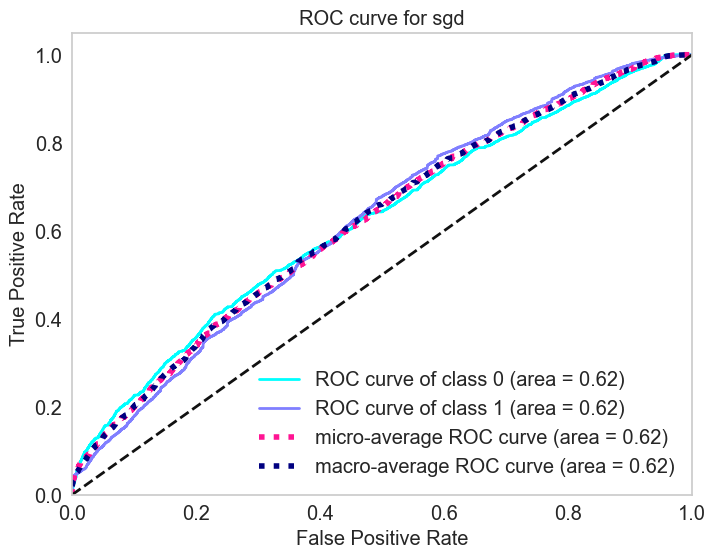

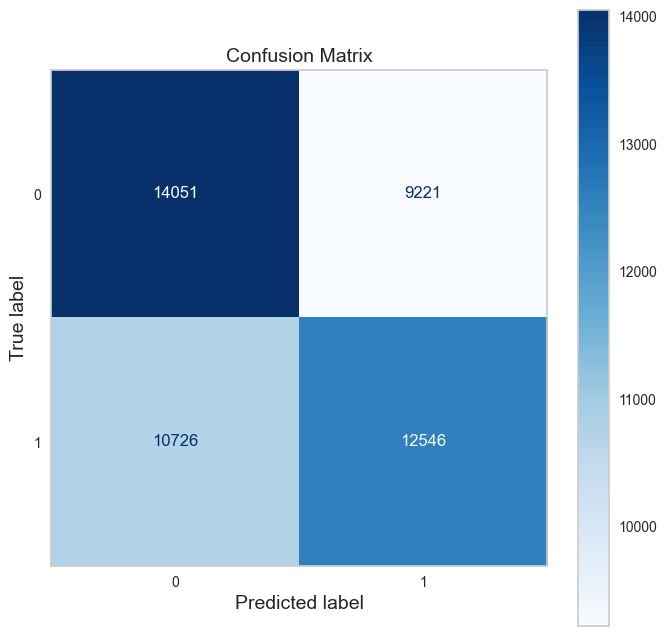



No feature importance for sgd






----------------------  logistic_regression  ----------------------


              precision    recall  f1-score   support

           0       0.58      0.57      0.58     23272
           1       0.58      0.60      0.59     23272

    accuracy                           0.58     46544
   macro avg       0.58      0.58      0.58     46544
weighted avg       0.58      0.58      0.58     46544



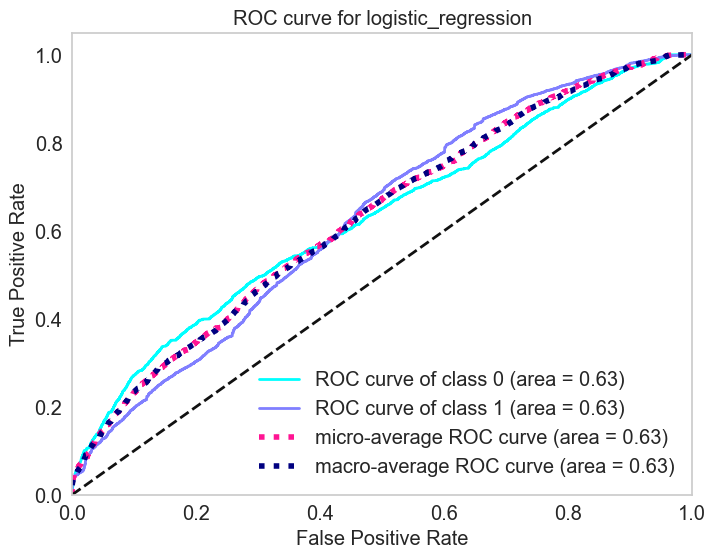

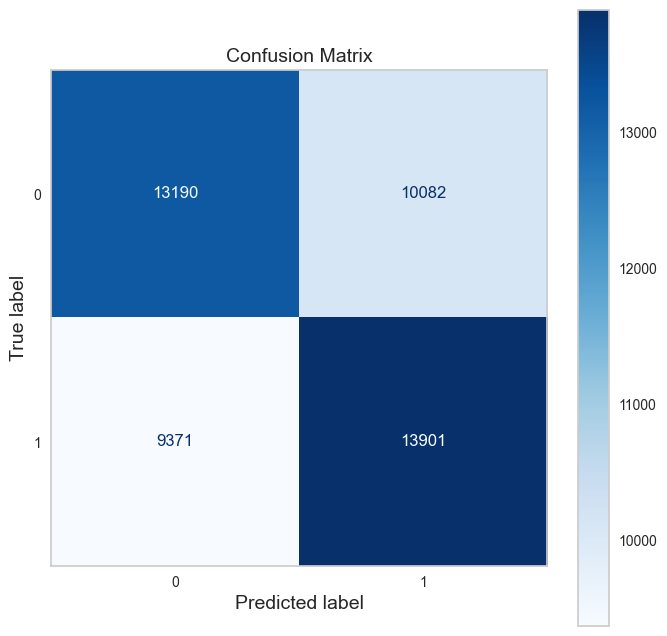

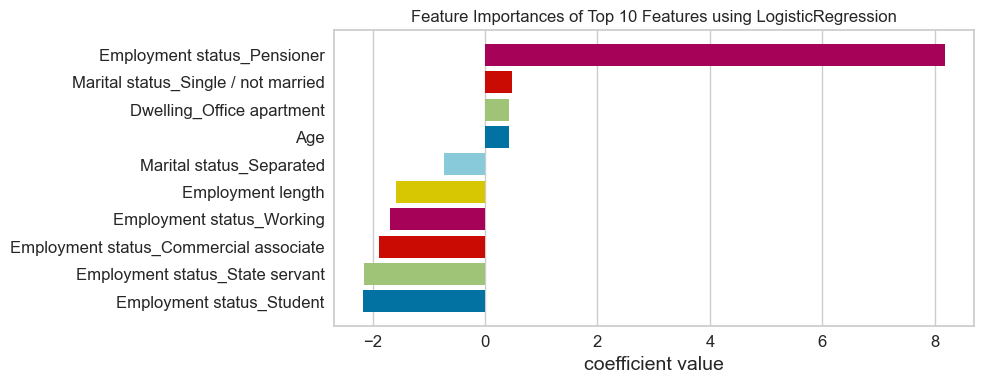

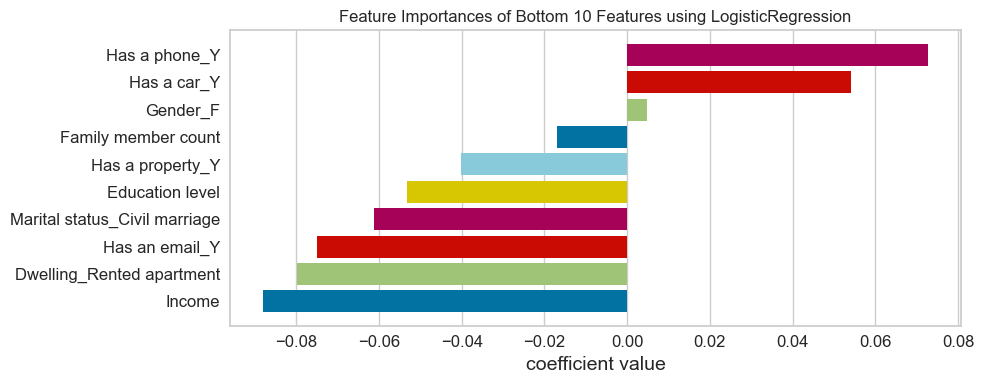







----------------------  gradient_boosting  ----------------------


              precision    recall  f1-score   support

           0       0.90      0.90      0.90     23272
           1       0.90      0.90      0.90     23272

    accuracy                           0.90     46544
   macro avg       0.90      0.90      0.90     46544
weighted avg       0.90      0.90      0.90     46544



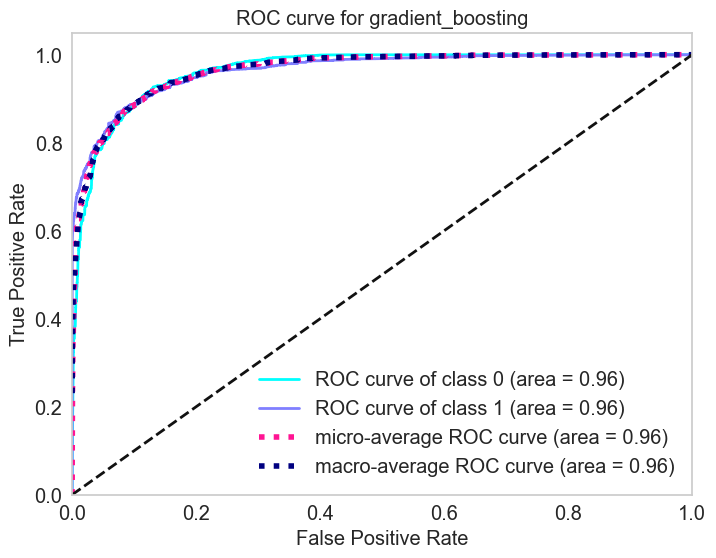

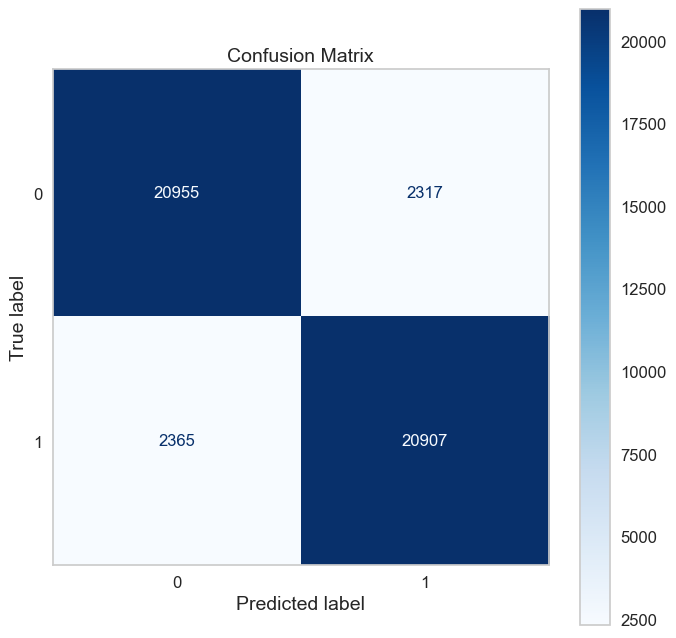

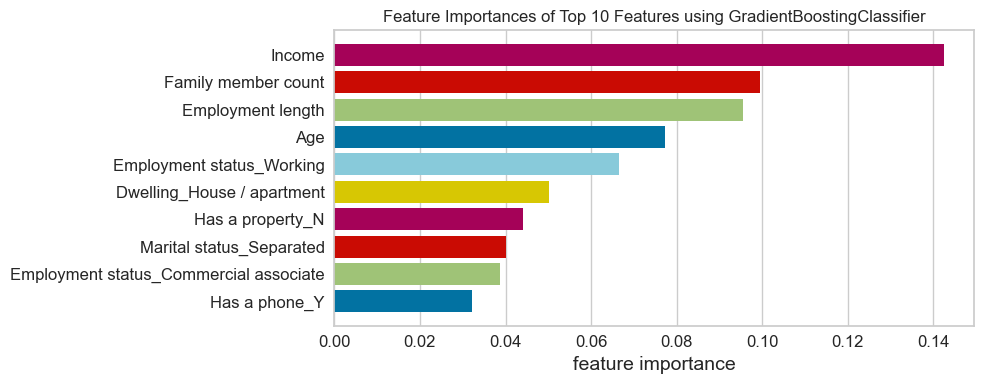

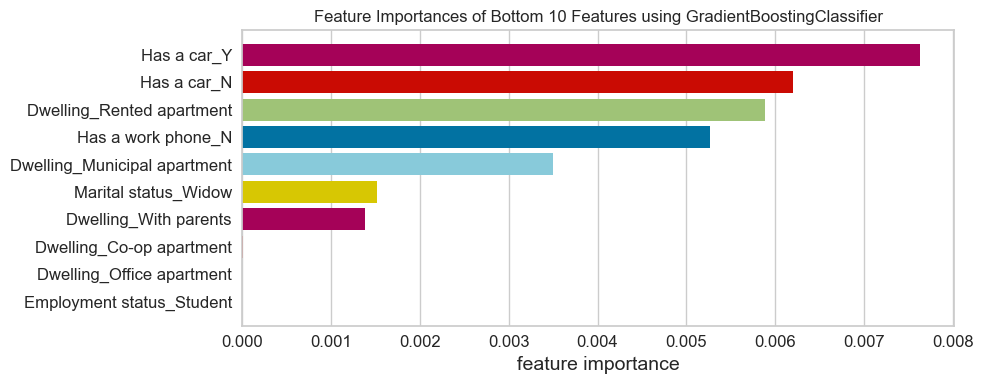







----------------------  decision_tree  ----------------------


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     23272
           1       0.98      0.98      0.98     23272

    accuracy                           0.98     46544
   macro avg       0.98      0.98      0.98     46544
weighted avg       0.98      0.98      0.98     46544



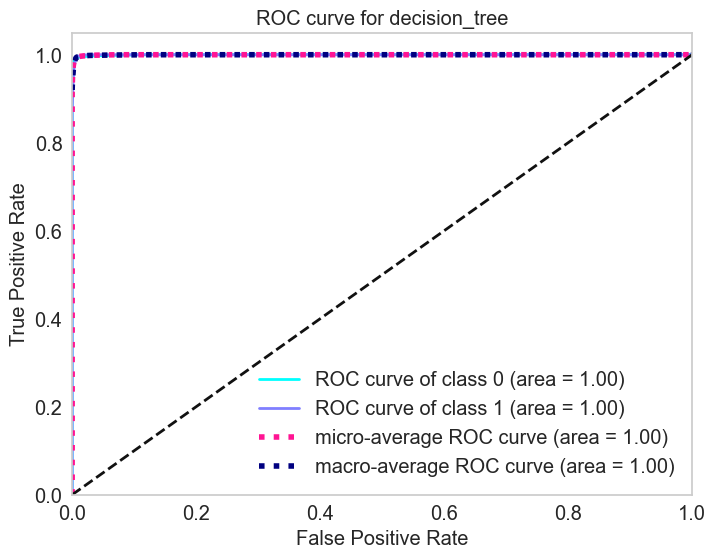

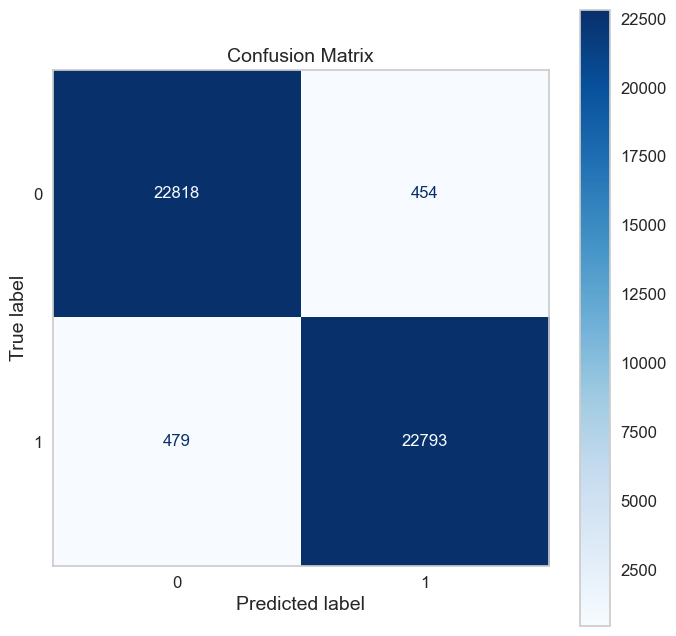

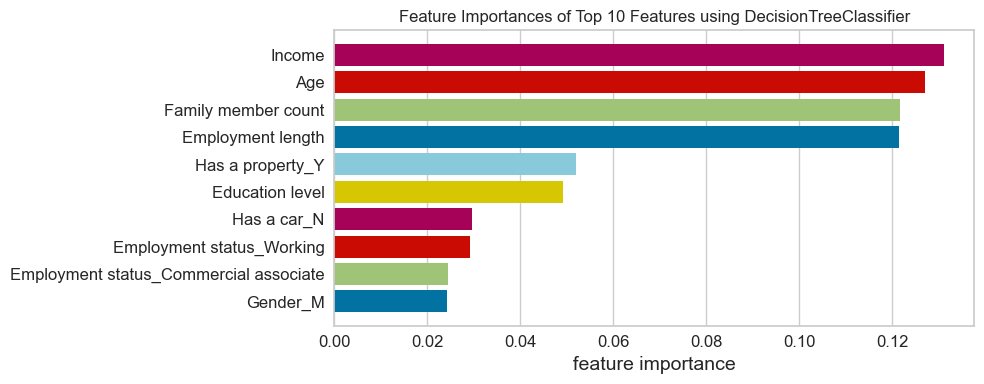

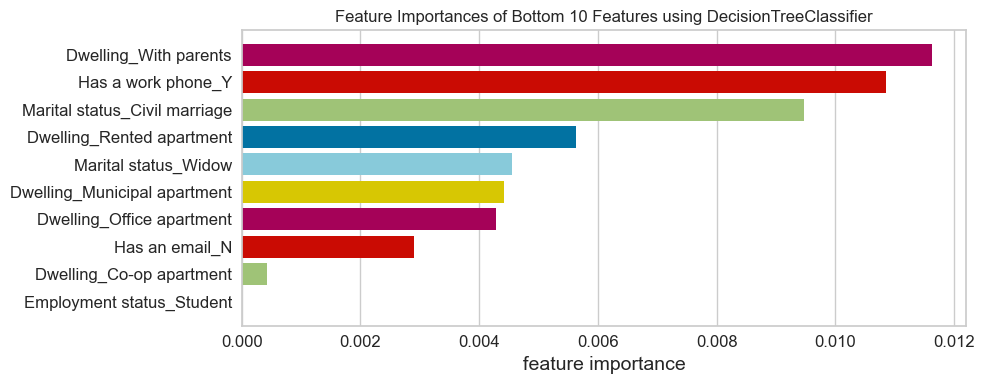







----------------------  random_forest  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



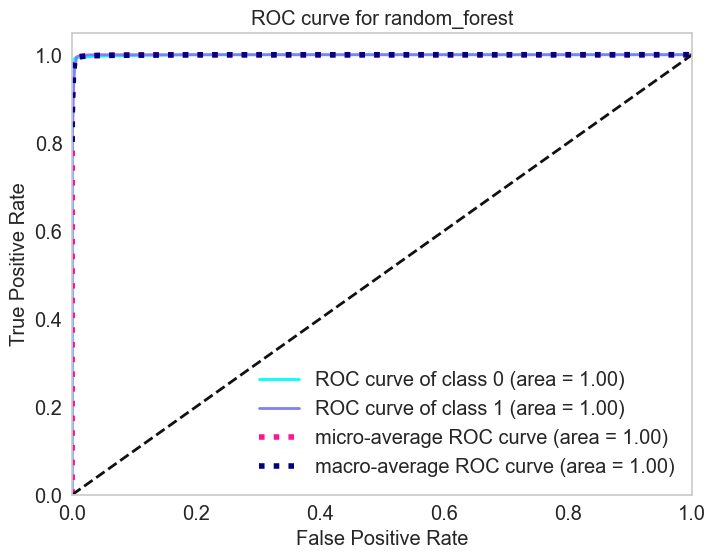

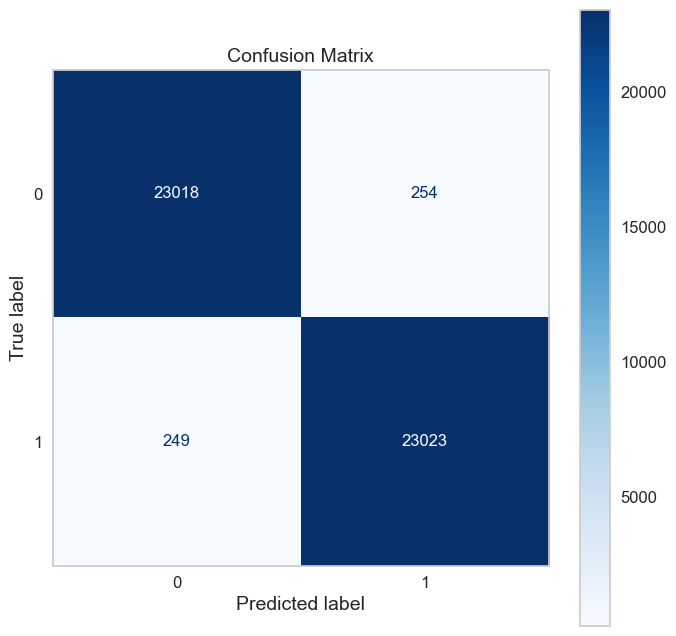

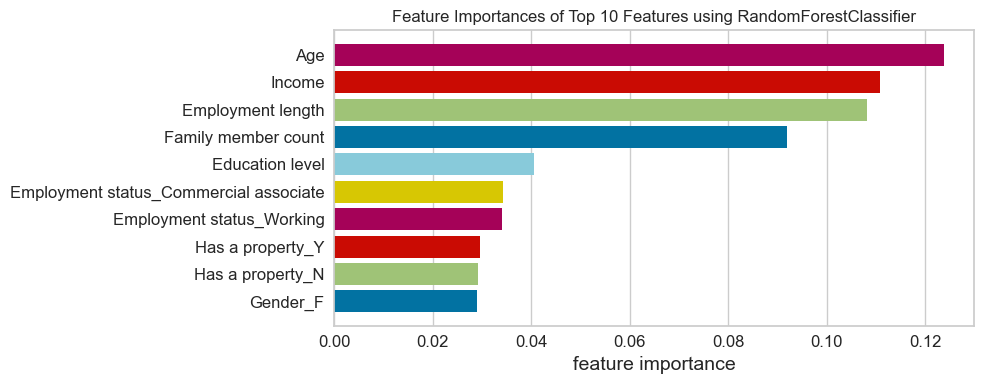

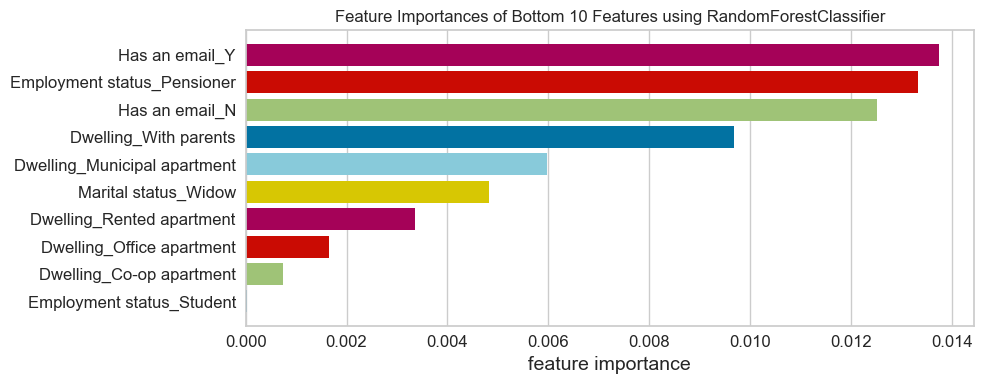







----------------------  k_nearest_neighbors  ----------------------


              precision    recall  f1-score   support

           0       0.93      0.96      0.94     23272
           1       0.96      0.93      0.94     23272

    accuracy                           0.94     46544
   macro avg       0.94      0.94      0.94     46544
weighted avg       0.94      0.94      0.94     46544



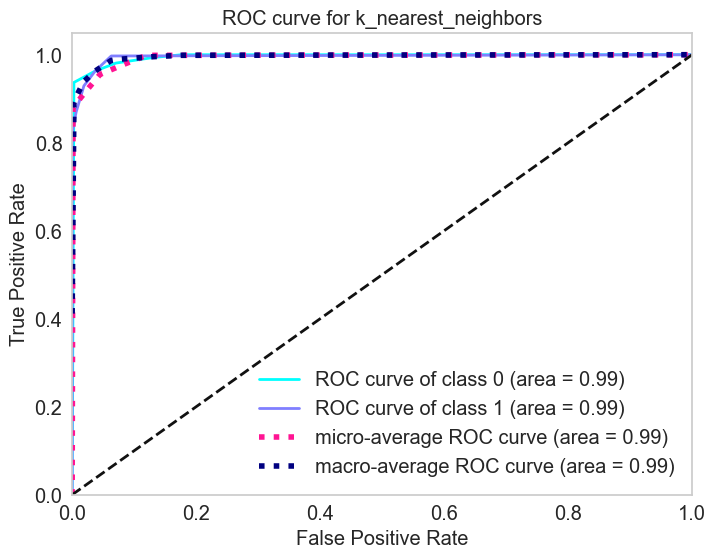

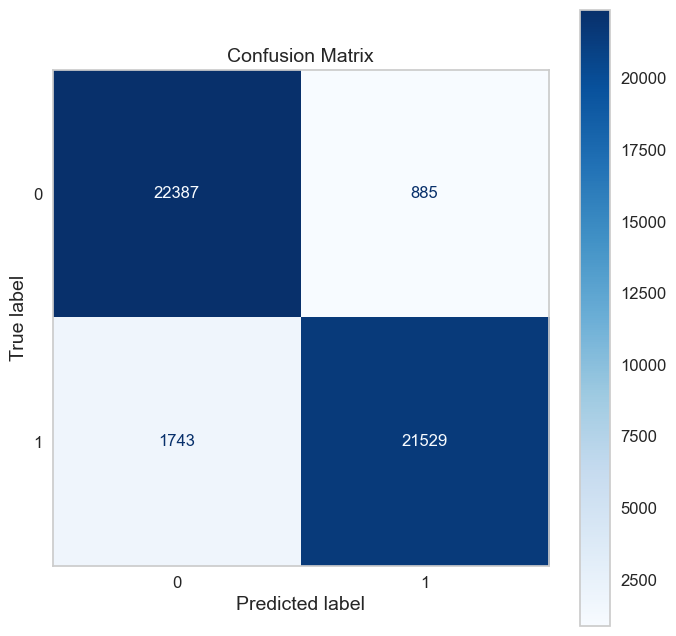



No feature importance for k_nearest_neighbors






----------------------  bagging  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



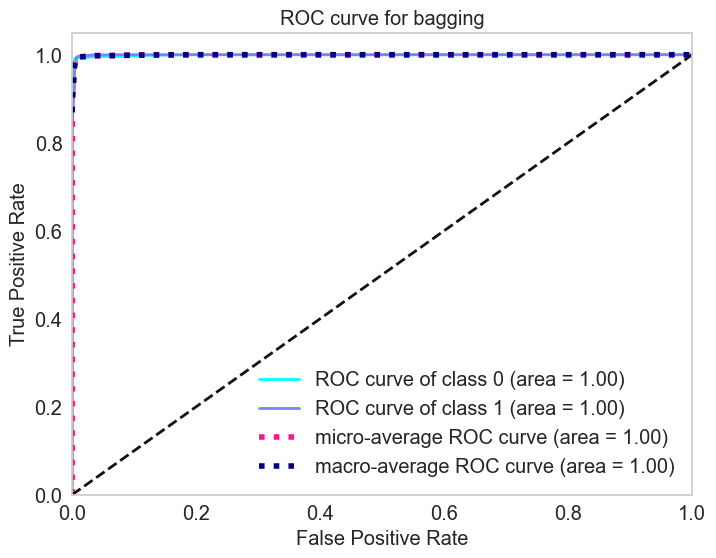

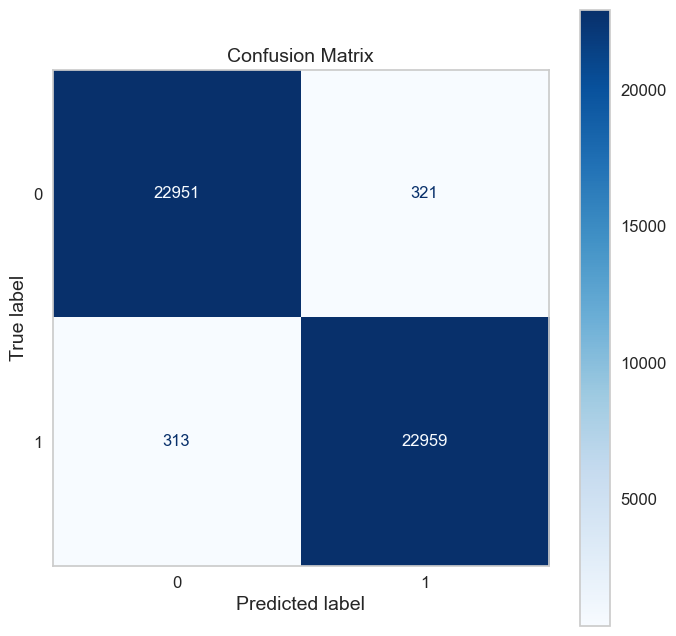



No feature importance for bagging






----------------------  adaboost  ----------------------


              precision    recall  f1-score   support

           0       0.77      0.75      0.76     23272
           1       0.76      0.78      0.77     23272

    accuracy                           0.76     46544
   macro avg       0.76      0.76      0.76     46544
weighted avg       0.76      0.76      0.76     46544



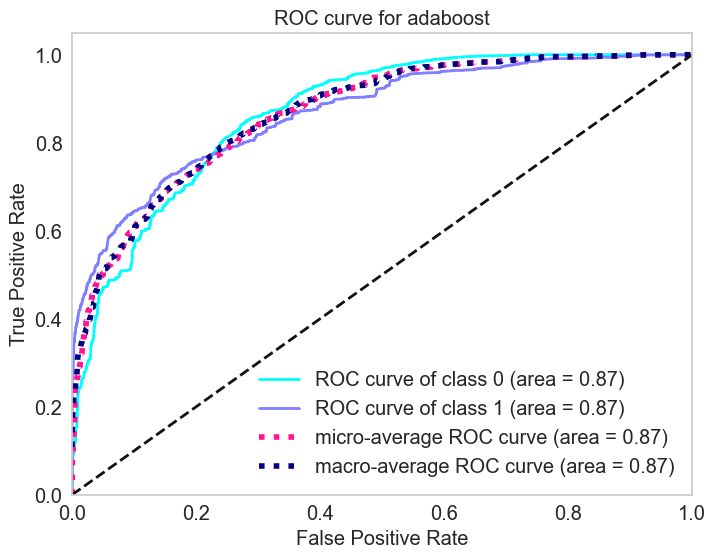

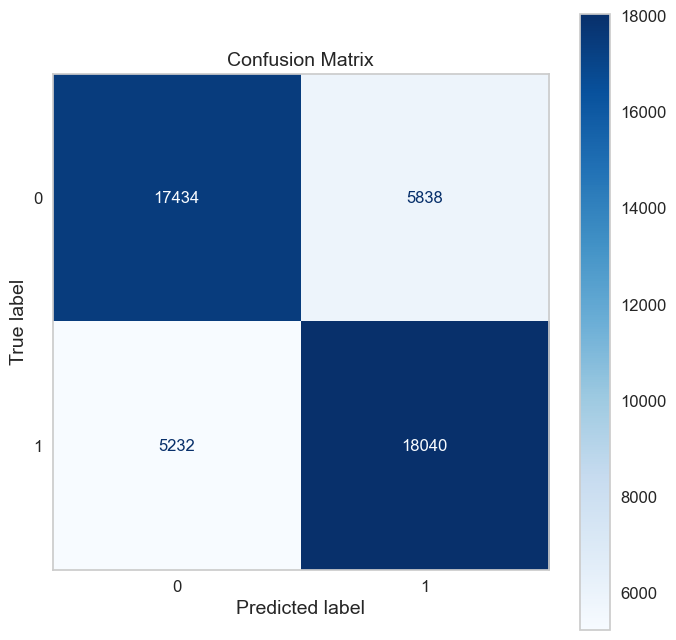

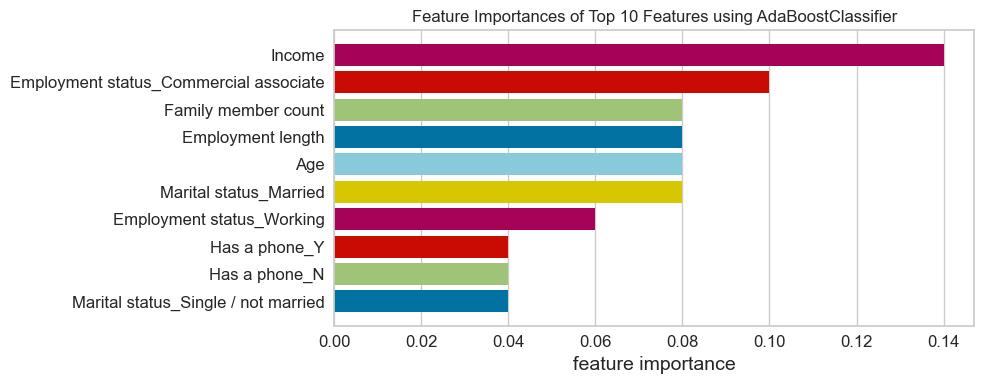

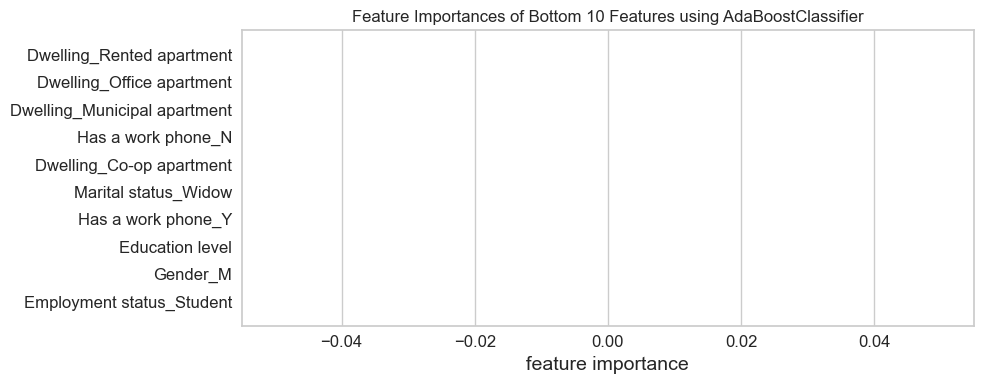

In [87]:
# loop over all the models
for model_name,model in classifiers.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model()
    # train the model
    model_trn = train_model(model,model_name)
    # print the scores from the classification report
    score_func(model_trn, model_name)
    # plot the ROC curve
    roc_curve_func(model_trn,model_name)
    # plot the confusion matrix
    confusion_matrix_func(model_trn,model_name)
    # plot feature importance
    feat_importance_plot(model_trn, model_name)
    warnings.filterwarnings("ignore")


In [88]:
test.head(5)

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5091261,F,N,Y,0,202500.0,State servant,Secondary / secondary special,Separated,House / apartment,-16834,-1692,1,0,0,0,Medicine staff,1.0,-6.0,0
1,5096963,M,Y,N,0,675000.0,Commercial associate,Higher education,Married,House / apartment,-18126,-948,1,0,1,0,Managers,2.0,-16.0,0
2,5087880,F,N,N,0,234000.0,State servant,Higher education,Civil marriage,House / apartment,-21967,-5215,1,0,0,1,Core staff,2.0,-52.0,0
3,5021949,F,Y,Y,0,445500.0,Commercial associate,Higher education,Married,House / apartment,-12477,-456,1,0,0,0,Managers,2.0,-54.0,0
4,5105705,F,Y,N,0,225000.0,Working,Secondary / secondary special,Married,Municipal apartment,-12155,-667,1,0,0,0,Laborers,2.0,-48.0,0


In [89]:
test_prep = full_pipeline(test)

In [90]:
X_test_prep, y_test_prep = test_prep.loc[:, test_prep.columns != 'Is high risk'], test_prep['Is high risk'].astype('int64')

In [96]:
model_trn = train_model(classifiers['random_forest'],'random_forest')

In [97]:
final_predictions = model_trn.predict(X_test_prep)

In [98]:
final_predictions.shape

(11654,)

In [99]:
n_correct = sum(final_predictions == y_test_prep)

In [100]:
print(n_correct/len(final_predictions))

0.879612150334649
